In [2]:
#importing the useful libraries
import sys
import scipy
import numpy as np
import seaborn as sn
import pandas as pd
pd.options.mode.chained_assignment = None 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.plotting import scatter_matrix
from pandas import read_csv
import sklearn
from sklearn import datasets
from sklearn import *
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
!pip install plotnine
from plotnine import *
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
# if using a Jupyter notebook, include:
%matplotlib inline

# 1. Data Cleansing

In [302]:
# importing the data from the IPA hosptial 
df = pd.read_excel('IPA.xlsx')

In [303]:
# the size of the data
df.shape

(59, 23)

In [304]:
#a quick look at the distribution of variables 
df.describe()

,GIA_Departmental_Gross_(at_ start)_m2,GIA_Building_Total_(at_start)_m2,GIA_(As_Built)_m2,Footprint_m2,Storeys_nr,Absolute_Duration_day,Inpatient_Beds_number,Inpatient_Beds%_Singles,Operating_Theatres_numbers,Outturn_Cost_GBP_UK,Percentage_of_Missing_Data%
count,24.000000,58.000000,24.000000,17.000000,50.00000,54.000000,38.000000,23.000000,26.000000,5.900000e+01,59.000000
mean,33873.916667,32813.022414,32522.554167,9921.294118,5.02000,256.277778,229.447368,76.043478,6.230769,1.028555e+08,32.896764
std,40406.131346,39182.764064,41156.543122,7451.063588,3.23558,5910.234623,277.610041,30.266210,6.470287,1.121312e+08,16.909626
min,3430.000000,3417.000000,0.000000,1783.000000,1.00000,-42140.000000,0.000000,0.000000,0.000000,9.356383e+06,0.000000
25%,12162.250000,9325.500000,12347.750000,5748.000000,3.00000,700.000000,68.000000,50.000000,0.750000,2.914612e+07,22.727273
50%,21057.500000,17369.000000,22999.650000,7577.000000,4.00000,920.500000,121.000000,100.000000,5.000000,6.397267e+07,40.909091
75%,29956.500000,31164.500000,30328.250000,13825.000000,6.75000,1248.500000,283.250000,100.000000,9.500000,1.239819e+08,45.454545
max,190000.000000,190000.000000,179353.000000,32000.000000,14.00000,3623.000000,1213.000000,100.000000,24.000000,6.017070e+08,54.545455


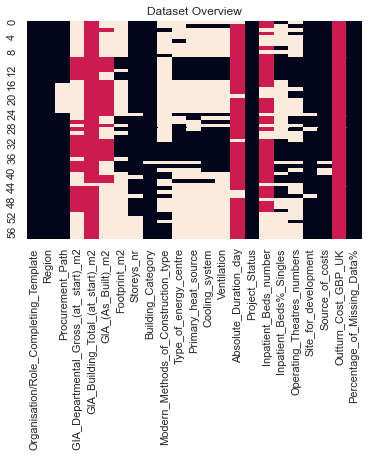

 categorical   Numeric   NaN 


In [305]:
#a heatmap to visualise which variables are categorical, which are Numeric and which have NAs
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"
    
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}
heatmap = df.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sn.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m categorical ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [306]:
# counting how many data have provided for each variable
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   print(df.count())

Organisation/Role_Completing_Template    59
Region                                   59
Procurement_Path                         51
GIA_Departmental_Gross_(at_ start)_m2    24
GIA_Building_Total_(at_start)_m2         58
GIA_(As_Built)_m2                        24
Footprint_m2                             17
Storeys_nr                               50
Building_Category                        58
Modern_Methods_of_Construction_type      18
Type_of_energy_centre                    20
Primary_heat_source                      19
Cooling_system                           22
Ventilation                              21
Absolute_Duration_day                    54
Project_Status                           59
Inpatient_Beds_number                    38
Inpatient_Beds%_Singles                  23
Operating_Theatres_numbers               26
Site_for_development                     56
Source_of_costs                          56
Outturn_Cost_GBP_UK                      59
Percentage_of_Missing_Data%     

In [307]:
# calculate the percentage of given data for each feature
p = df.count()/59 * 100
print(p)

Organisation/Role_Completing_Template    100.000000
Region                                   100.000000
Procurement_Path                          86.440678
GIA_Departmental_Gross_(at_ start)_m2     40.677966
GIA_Building_Total_(at_start)_m2          98.305085
GIA_(As_Built)_m2                         40.677966
Footprint_m2                              28.813559
Storeys_nr                                84.745763
Building_Category                         98.305085
Modern_Methods_of_Construction_type       30.508475
Type_of_energy_centre                     33.898305
Primary_heat_source                       32.203390
Cooling_system                            37.288136
Ventilation                               35.593220
Absolute_Duration_day                     91.525424
Project_Status                           100.000000
Inpatient_Beds_number                     64.406780
Inpatient_Beds%_Singles                   38.983051
Operating_Theatres_numbers                44.067797
Site_for_dev

In [308]:
# counting the number of 0 in each column
59 - df.astype(bool).sum(axis=0)

Organisation/Role_Completing_Template    0
Region                                   0
Procurement_Path                         0
GIA_Departmental_Gross_(at_ start)_m2    0
GIA_Building_Total_(at_start)_m2         0
GIA_(As_Built)_m2                        2
Footprint_m2                             0
Storeys_nr                               0
Building_Category                        0
Modern_Methods_of_Construction_type      0
Type_of_energy_centre                    0
Primary_heat_source                      0
Cooling_system                           0
Ventilation                              0
Absolute_Duration_day                    0
Project_Status                           0
Inpatient_Beds_number                    1
Inpatient_Beds%_Singles                  1
Operating_Theatres_numbers               7
Site_for_development                     0
Source_of_costs                          0
Outturn_Cost_GBP_UK                      0
Percentage_of_Missing_Data%              4
dtype: int6

In [207]:
# Separate numeric and categorical variables
# nd stands for numerical data
nd = df.select_dtypes(include=[np.number])
# cd stands for categorical data
cd = df.select_dtypes(exclude=[np.number])

In [309]:
# Variables Selection
# Step1: drop the features which has less than 40% completement 
df = df.drop(columns=['Footprint_m2','Modern_Methods_of_Construction_type','Type_of_energy_centre','Primary_heat_source','Cooling_system','Ventilation','Inpatient_Beds%_Singles'])

In [310]:
# Drop the Absolute_Duration_day that is smaller than 100 days
df = df[(df['Absolute_Duration_day'] >= 100) | (df['Absolute_Duration_day'].isnull())]

# 2. Exploratory Data Analysis

In [15]:
# define a functino to abstract desired data from the excel;
# and convert to a list
def list_1(x):
    y = df[x].tolist()
    return y

# convert desired data to an array 
# replace all 'nan' in the array with 0, 
# and recieve the final array version of our data
def array(x):
    z = np.array(list_1(x))
    x = np.nan_to_num(z)
    return x

# 2.1 Data Distributions

Looking at the distribution of each variable shows the range and frequency of values.

In [17]:
# convert the numerical data in the previous dataframe into array form
gbtas = array('GIA_Building_Total_(at_start)_m2')
gab = array('GIA_(As_Built)_m2')
s = array('Storeys_nr')
ab = array('Absolute_Duration_day')
ib = array('Inpatient_Beds_number')
ibs = array('Percentage_of_Missing_Data%')
ot = array('Operating_Theatres_numbers')
oc = array('Outturn_Cost_GBP_UK')

Numerical Data

[Text(0, 0.5, 'Projects'), Text(0.5, 0, 'Outturn_Cost_GBP_UK')]

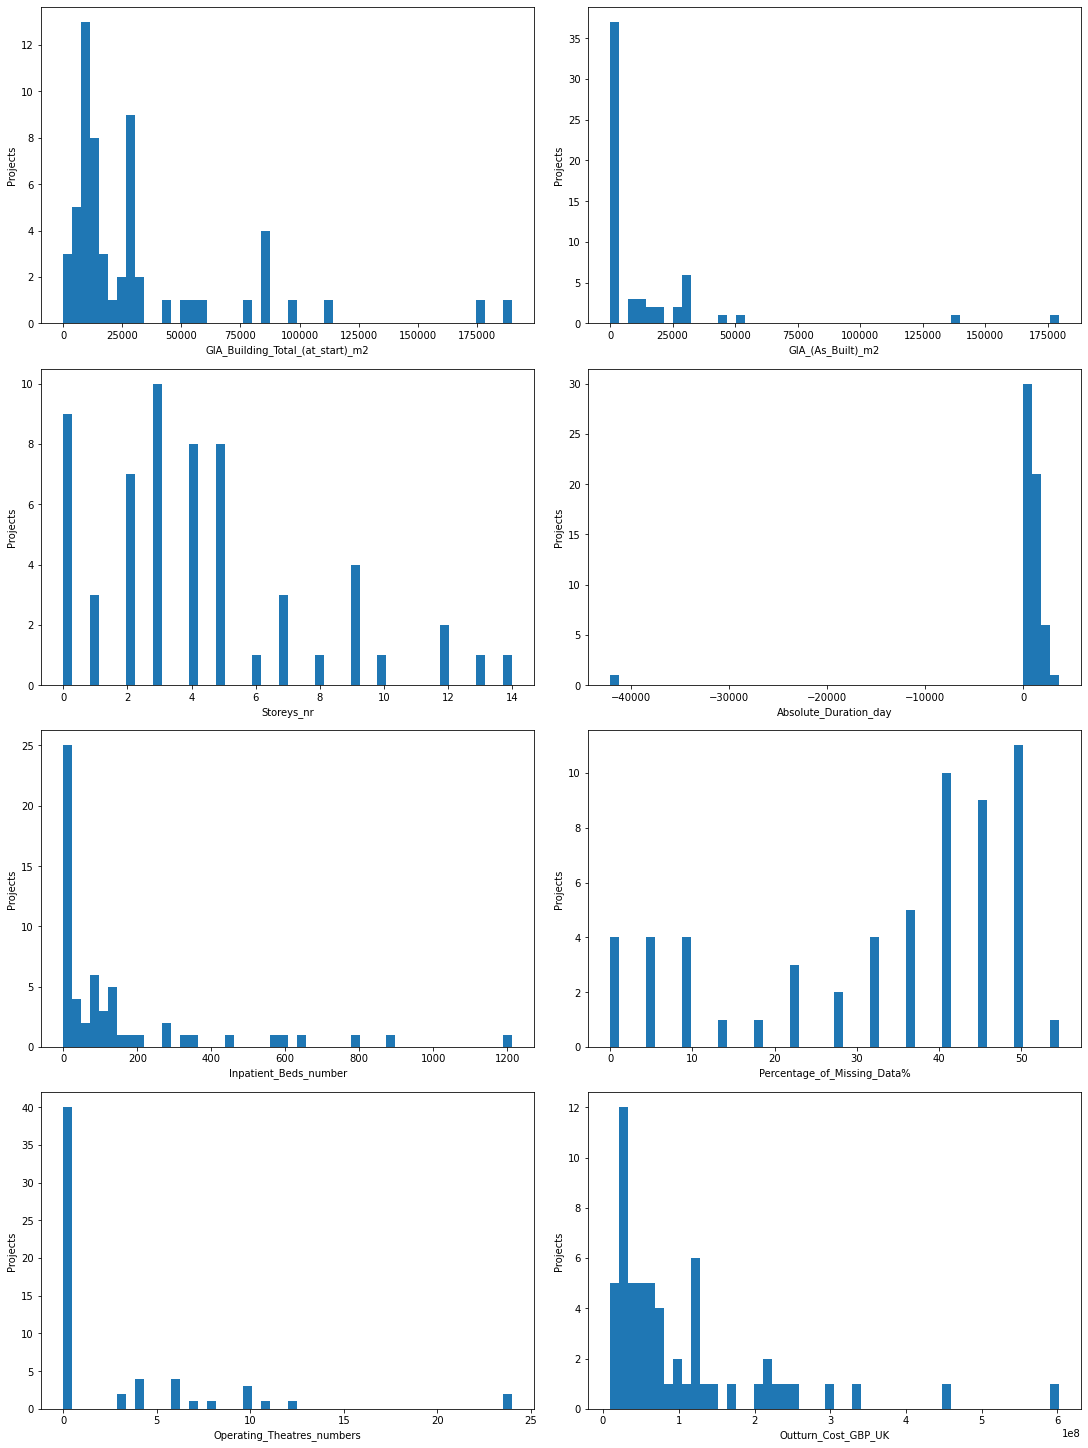

In [18]:
# create 8 subplots and unpack the output array 
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8)) = plt.subplots(4,2,figsize=(15,20), constrained_layout=True)

#histogram of project duration
ax1.hist(x = gbtas, bins= 50)
ax1.set(xlabel = 'GIA_Building_Total_(at_start)_m2', ylabel = 'Projects')
ax2.hist(x = gab, bins= 50)
ax2.set(xlabel = 'GIA_(As_Built)_m2', ylabel = 'Projects')
ax3.hist(x = s, bins= 50)
ax3.set(xlabel = 'Storeys_nr', ylabel = 'Projects')
ax4.hist(x = ab, bins= 50)
ax4.set(xlabel = 'Absolute_Duration_day', ylabel = 'Projects')
ax5.hist(x = ib, bins= 50)
ax5.set(xlabel = 'Inpatient_Beds_number', ylabel = 'Projects')
ax6.hist(x = ibs, bins= 50)
ax6.set(xlabel = 'Percentage_of_Missing_Data%', ylabel = 'Projects')
ax7.hist(x = ot, bins= 50)
ax7.set(xlabel = 'Operating_Theatres_numbers', ylabel = 'Projects')
ax8.hist(x = oc, bins= 50)
ax8.set(xlabel = 'Outturn_Cost_GBP_UK', ylabel = 'Projects')


Categorical Data

In [24]:
# define a function to count the number of different data for each variable
# exclude 'nan'
def num(x):
    a = df[x].dropna().unique().tolist()
    number = len(a)
    return number

# define a function to count the frequency of each element 
def freq(x):
    arr = df[x].dropna().tolist()
    elements_count = {}
    for element in arr:
        if element in elements_count:
            elements_count[element] += 1
        else:
            elements_count[element] = 1
    keys_values = elements_count.items()
    freq = {key:value for key, value in keys_values}
    return freq

# def a function to list the types of elements for each varibales
def key(x):
    keys = [key for key in freq(x)]
    return keys

# def a function to list the frequency of each element 
def value(x):
    a = freq(x).values()
    return list(a)

In [25]:
# rename each variable
orct = 'Organisation/Role_Completing_Template'
pp = 'Procurement_Path'
r = 'Region'
bc = 'Building_Category'
ps = 'Project_Status'
sd = 'Site_for_development'
sc = 'Source_of_costs'

Procurement_Path:

Text(0.5, 0.98, 'Categorical Plotting\nProcurement_Path')

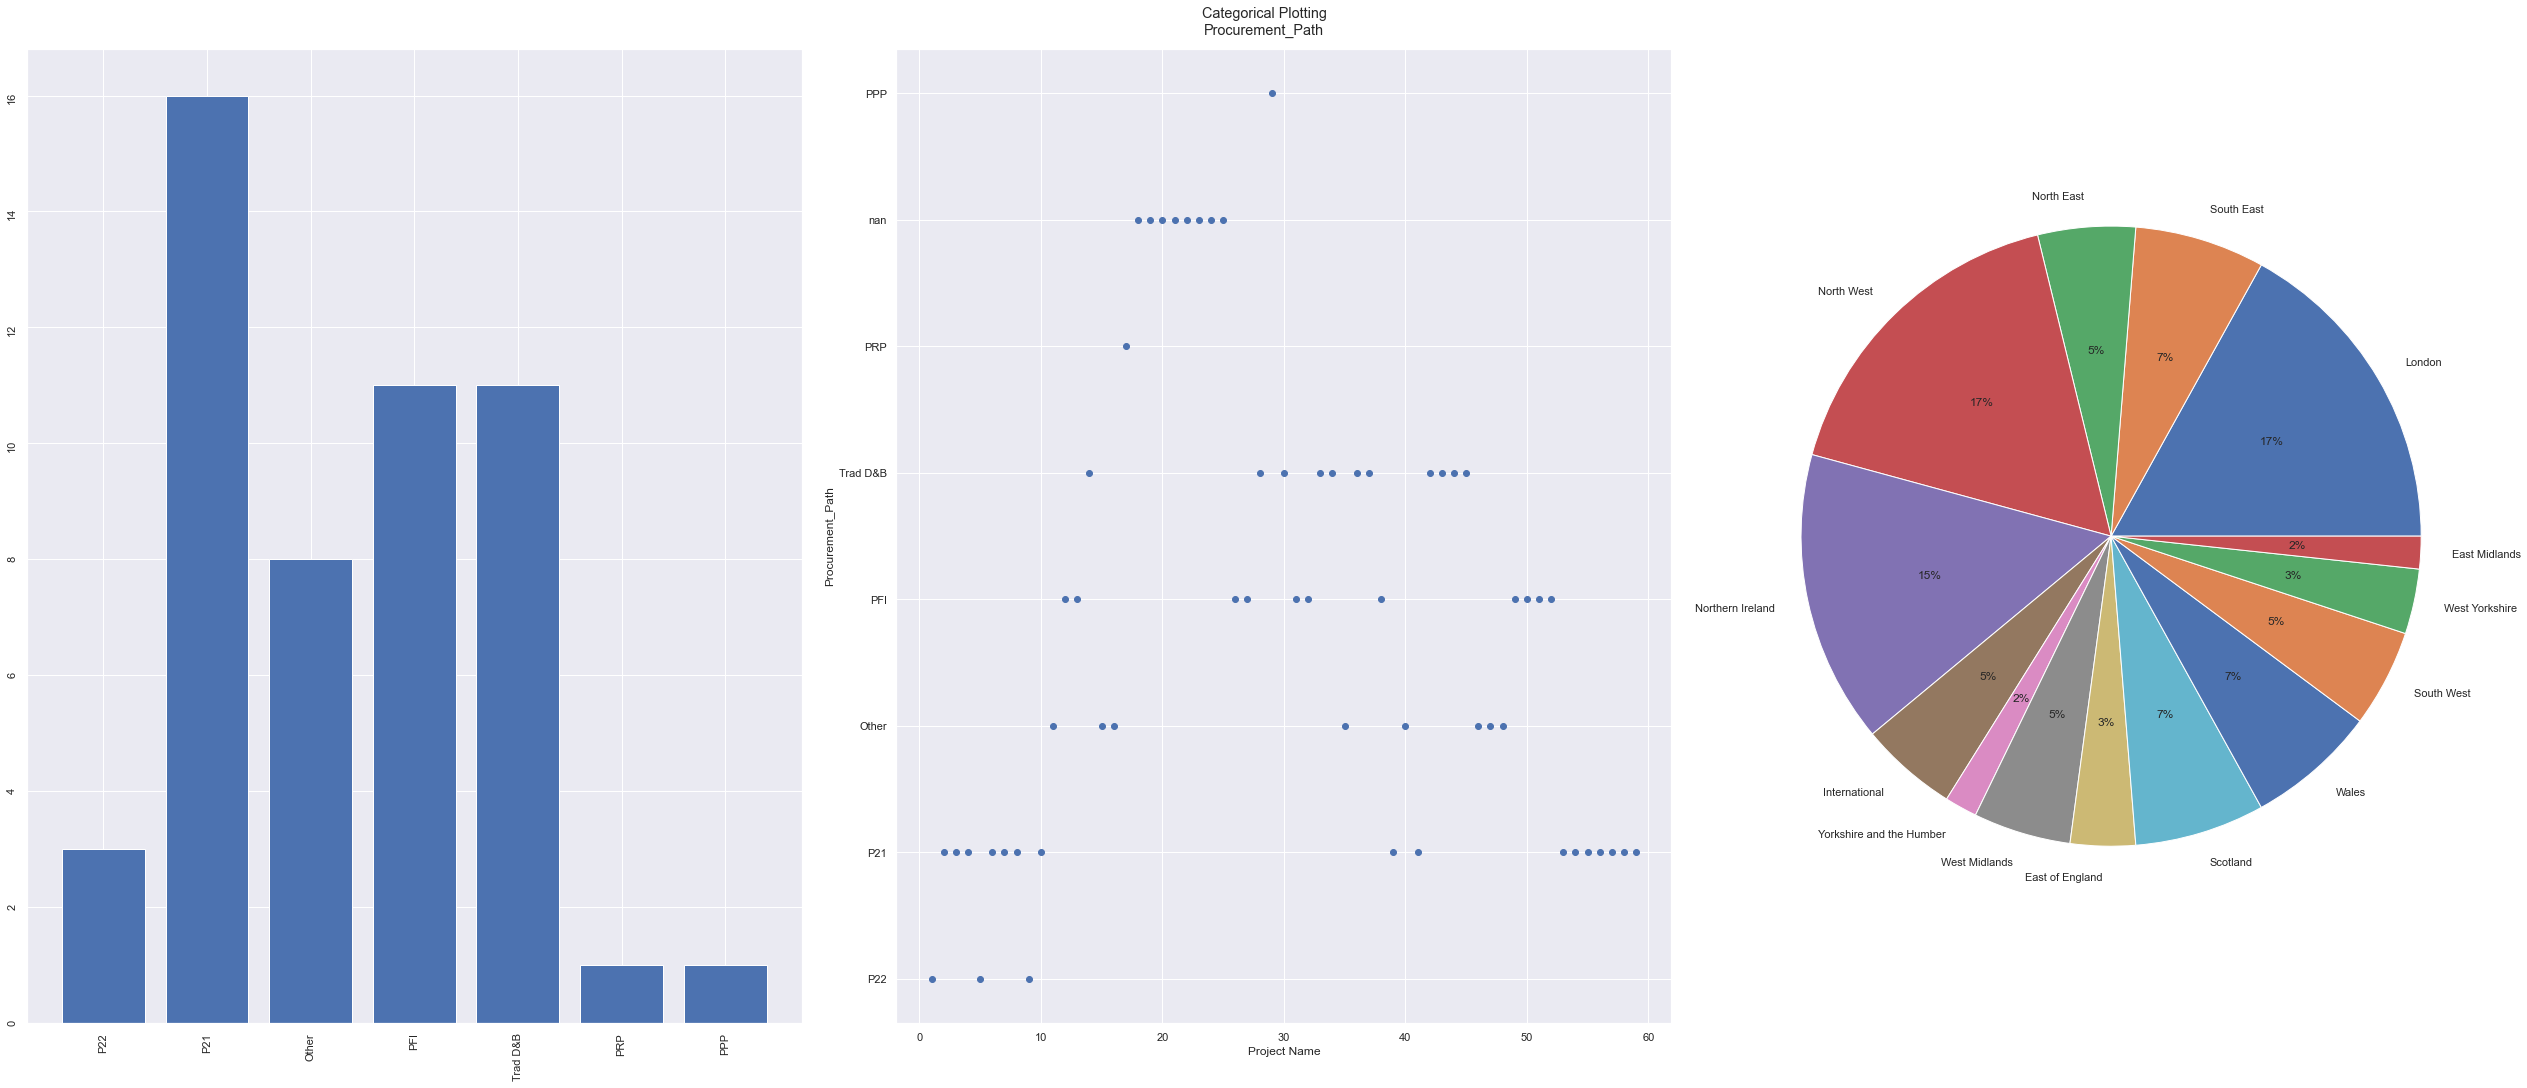

In [72]:
fig, (ax7, ax9, ax31) = plt.subplots(1, 3, figsize = (35, 15), constrained_layout=True)
# bar chart
ax7.bar(key(pp), value(pp))
ax7.tick_params(labelrotation=90)

# scattering plot
x = np.arange(1,60)
y = np.array(list_1(pp))
ax9.scatter(x, y)
ax9.set(xlabel = 'Project Name', ylabel = 'Procurement_Path')

# pie chart 
labels = key(r)
nums = value(r)
ax31.pie(nums, labels = labels, autopct='%.0f%%')
fig.suptitle('Categorical Plotting\nProcurement_Path')

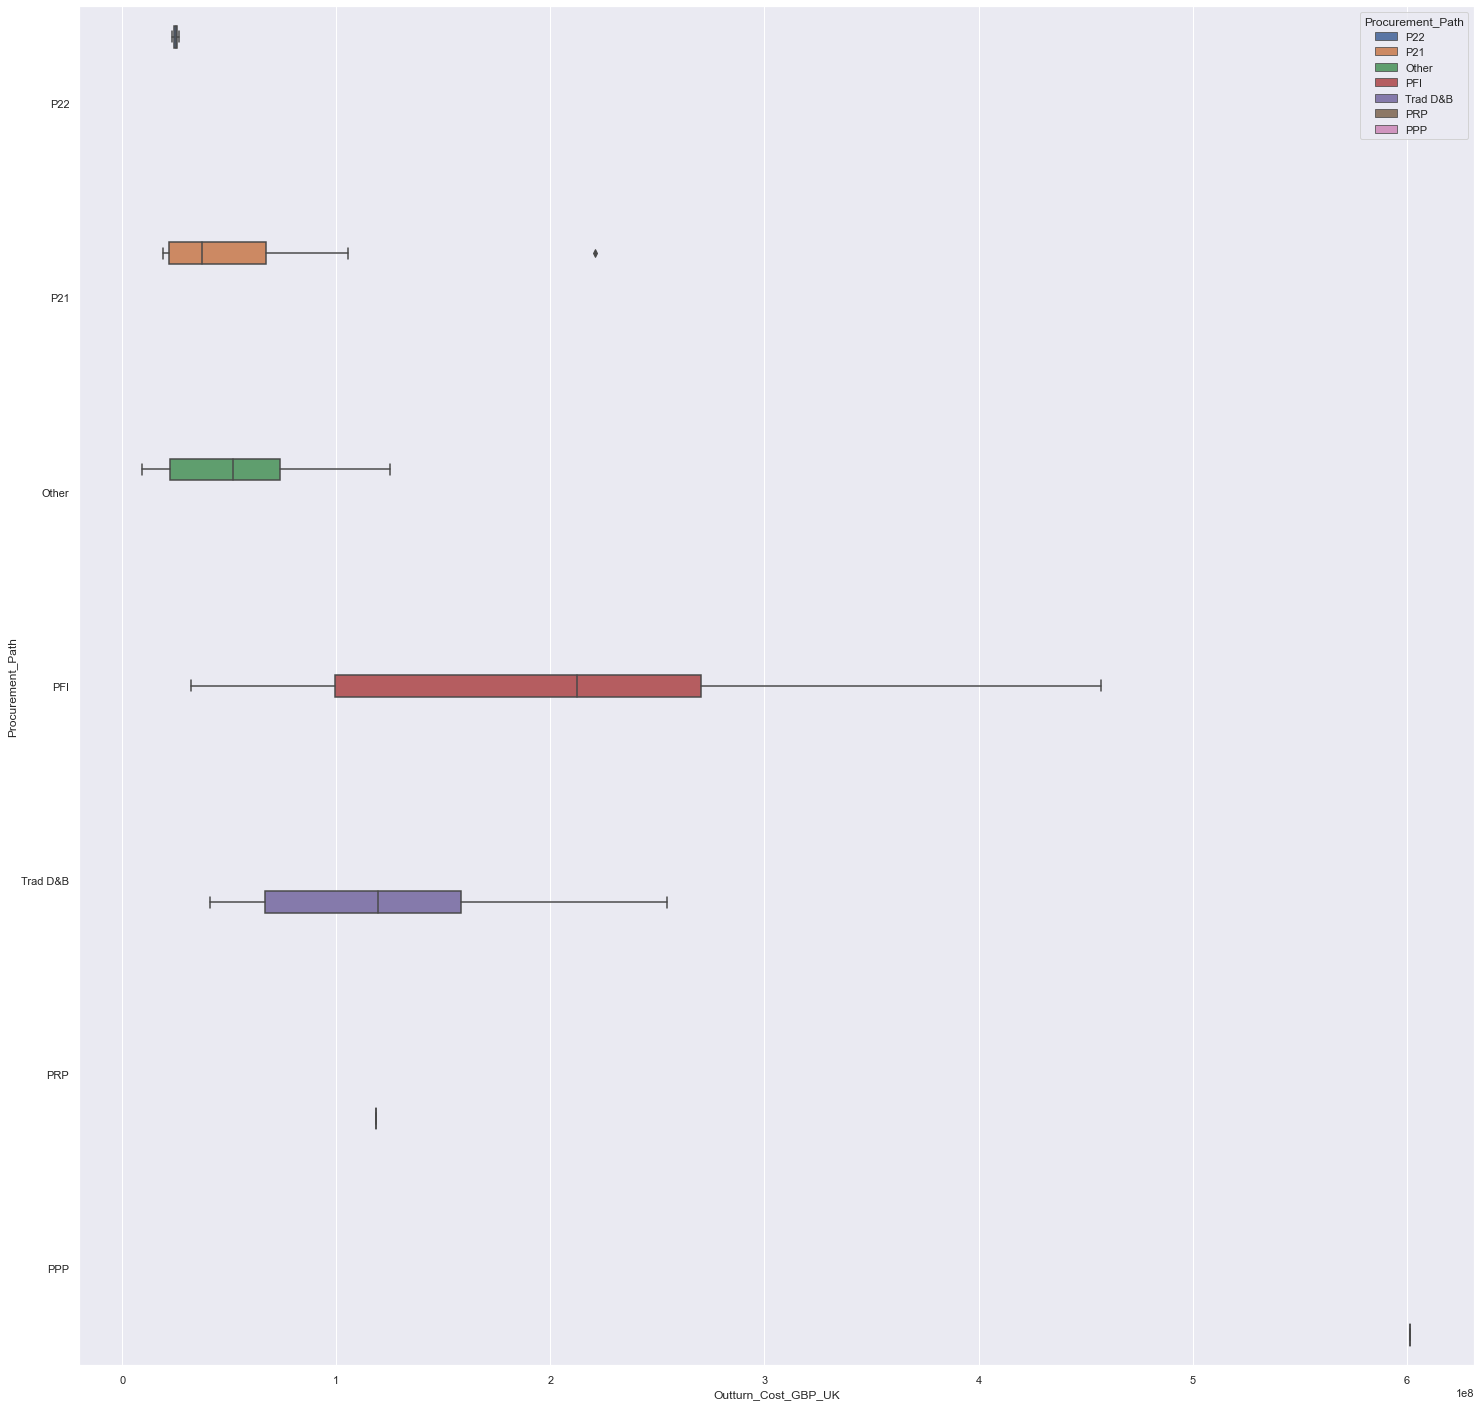

In [73]:
sn.boxplot(y='Procurement_Path',x='Outturn_Cost_GBP_UK', 
           data=df, hue='Procurement_Path')
sn.set(rc={'figure.figsize':(40,45)})

Region:

Text(0.5, 0.98, 'Categorical Plotting\nRegion')

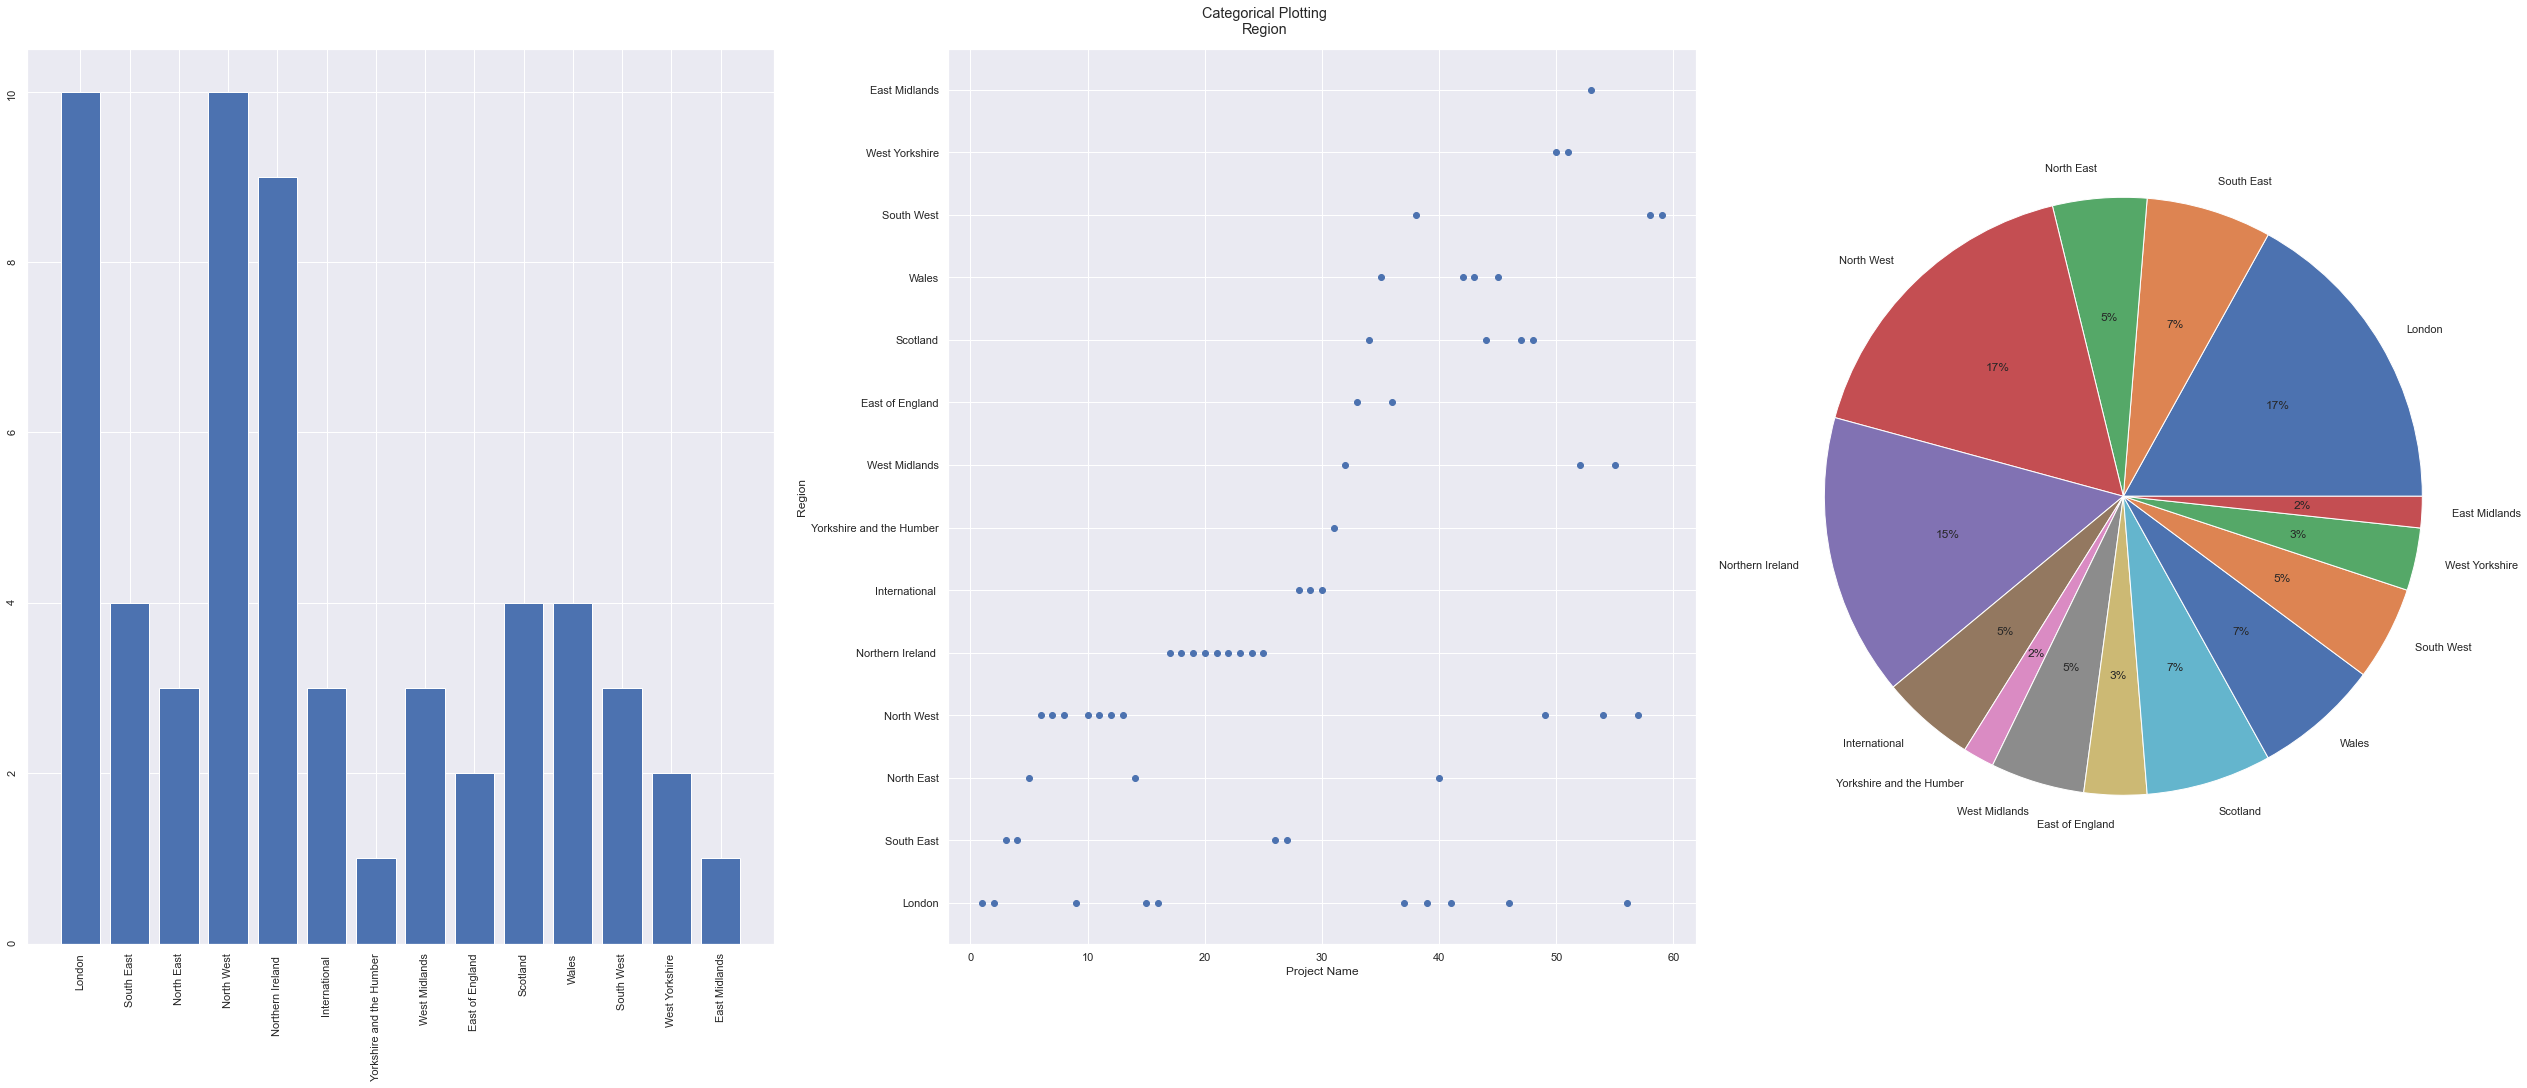

In [30]:
fig, (ax7, ax9, ax31) = plt.subplots(1, 3, figsize = (35, 15), constrained_layout=True)
# bar chart
ax7.bar(key(r), value(r))
ax7.tick_params(labelrotation=90)

# scattering plot
x = np.arange(1,60)
y = np.array(list_1(r))
ax9.scatter(x, y)
ax9.set(xlabel = 'Project Name', ylabel = 'Region')

# pie chart 
labels = key(r)
nums = value(r)
ax31.pie(nums, labels = labels, autopct='%.0f%%')
fig.suptitle('Categorical Plotting\nRegion')

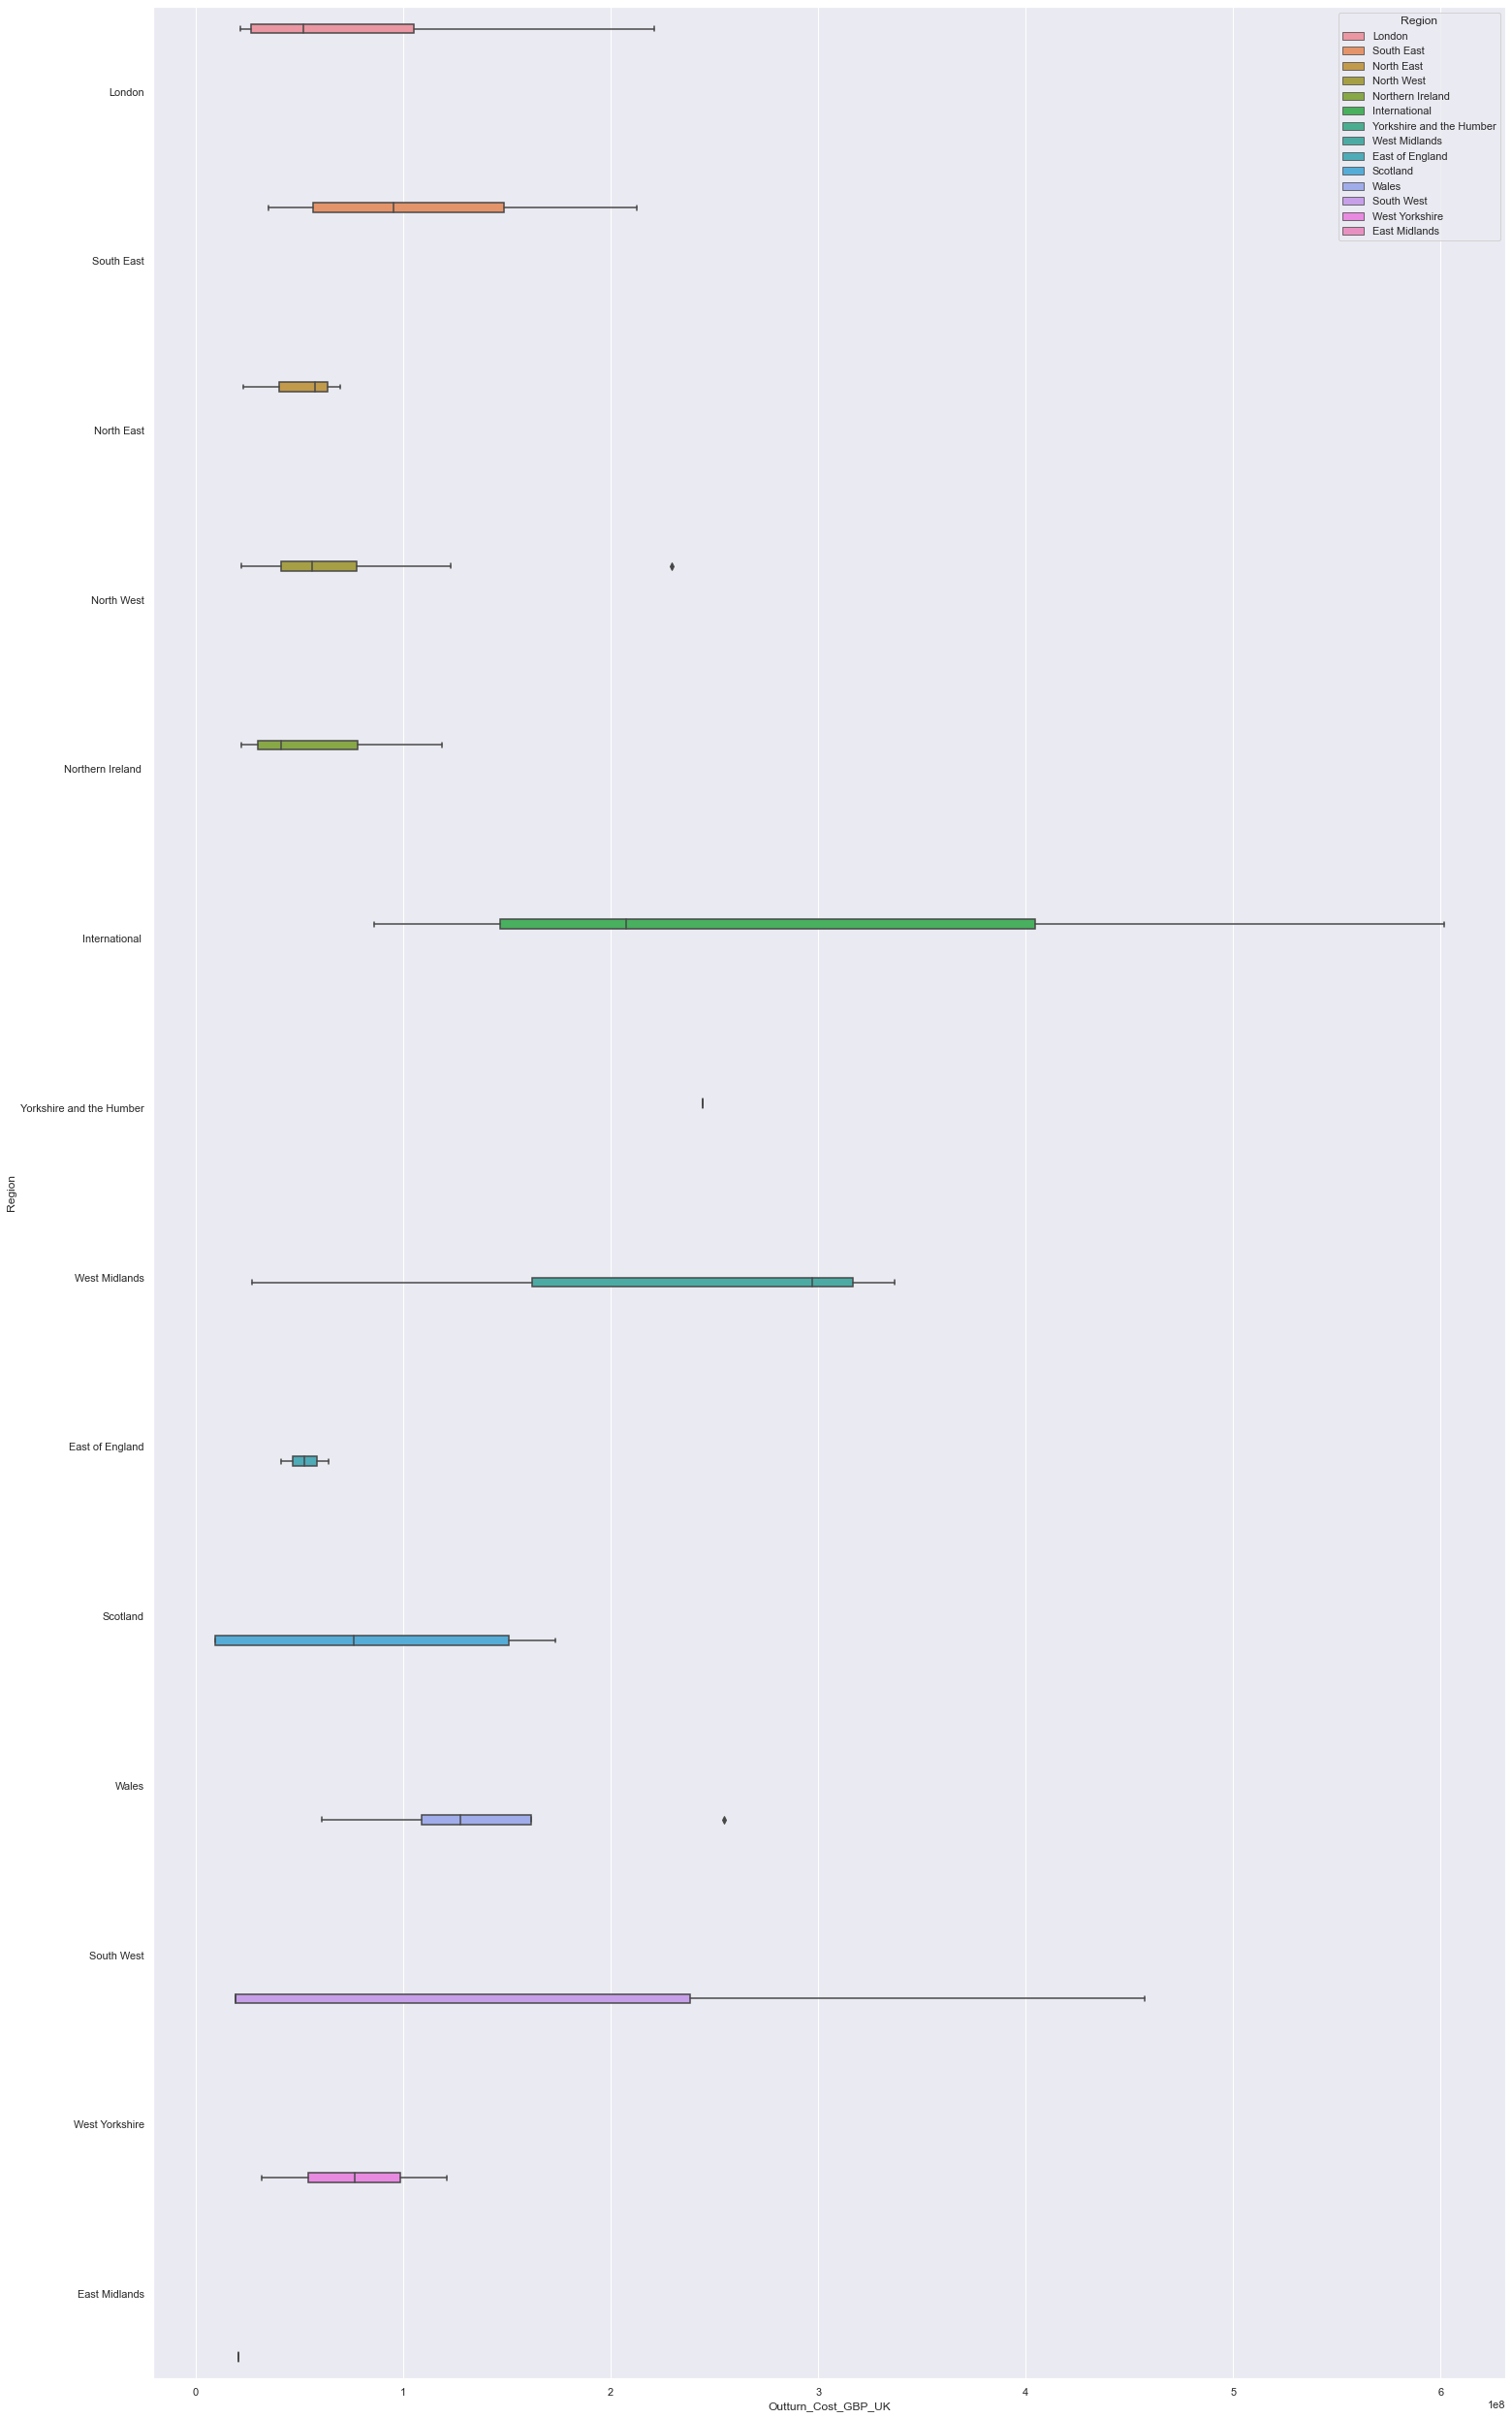

In [38]:
sn.boxplot(y='Region',x='Outturn_Cost_GBP_UK', 
           data=df, hue='Region')
sn.set(rc={'figure.figsize':(40,45)})

Building_Category:

Text(0.5, 0.98, 'Categorical Plotting\nBuilding_Category')

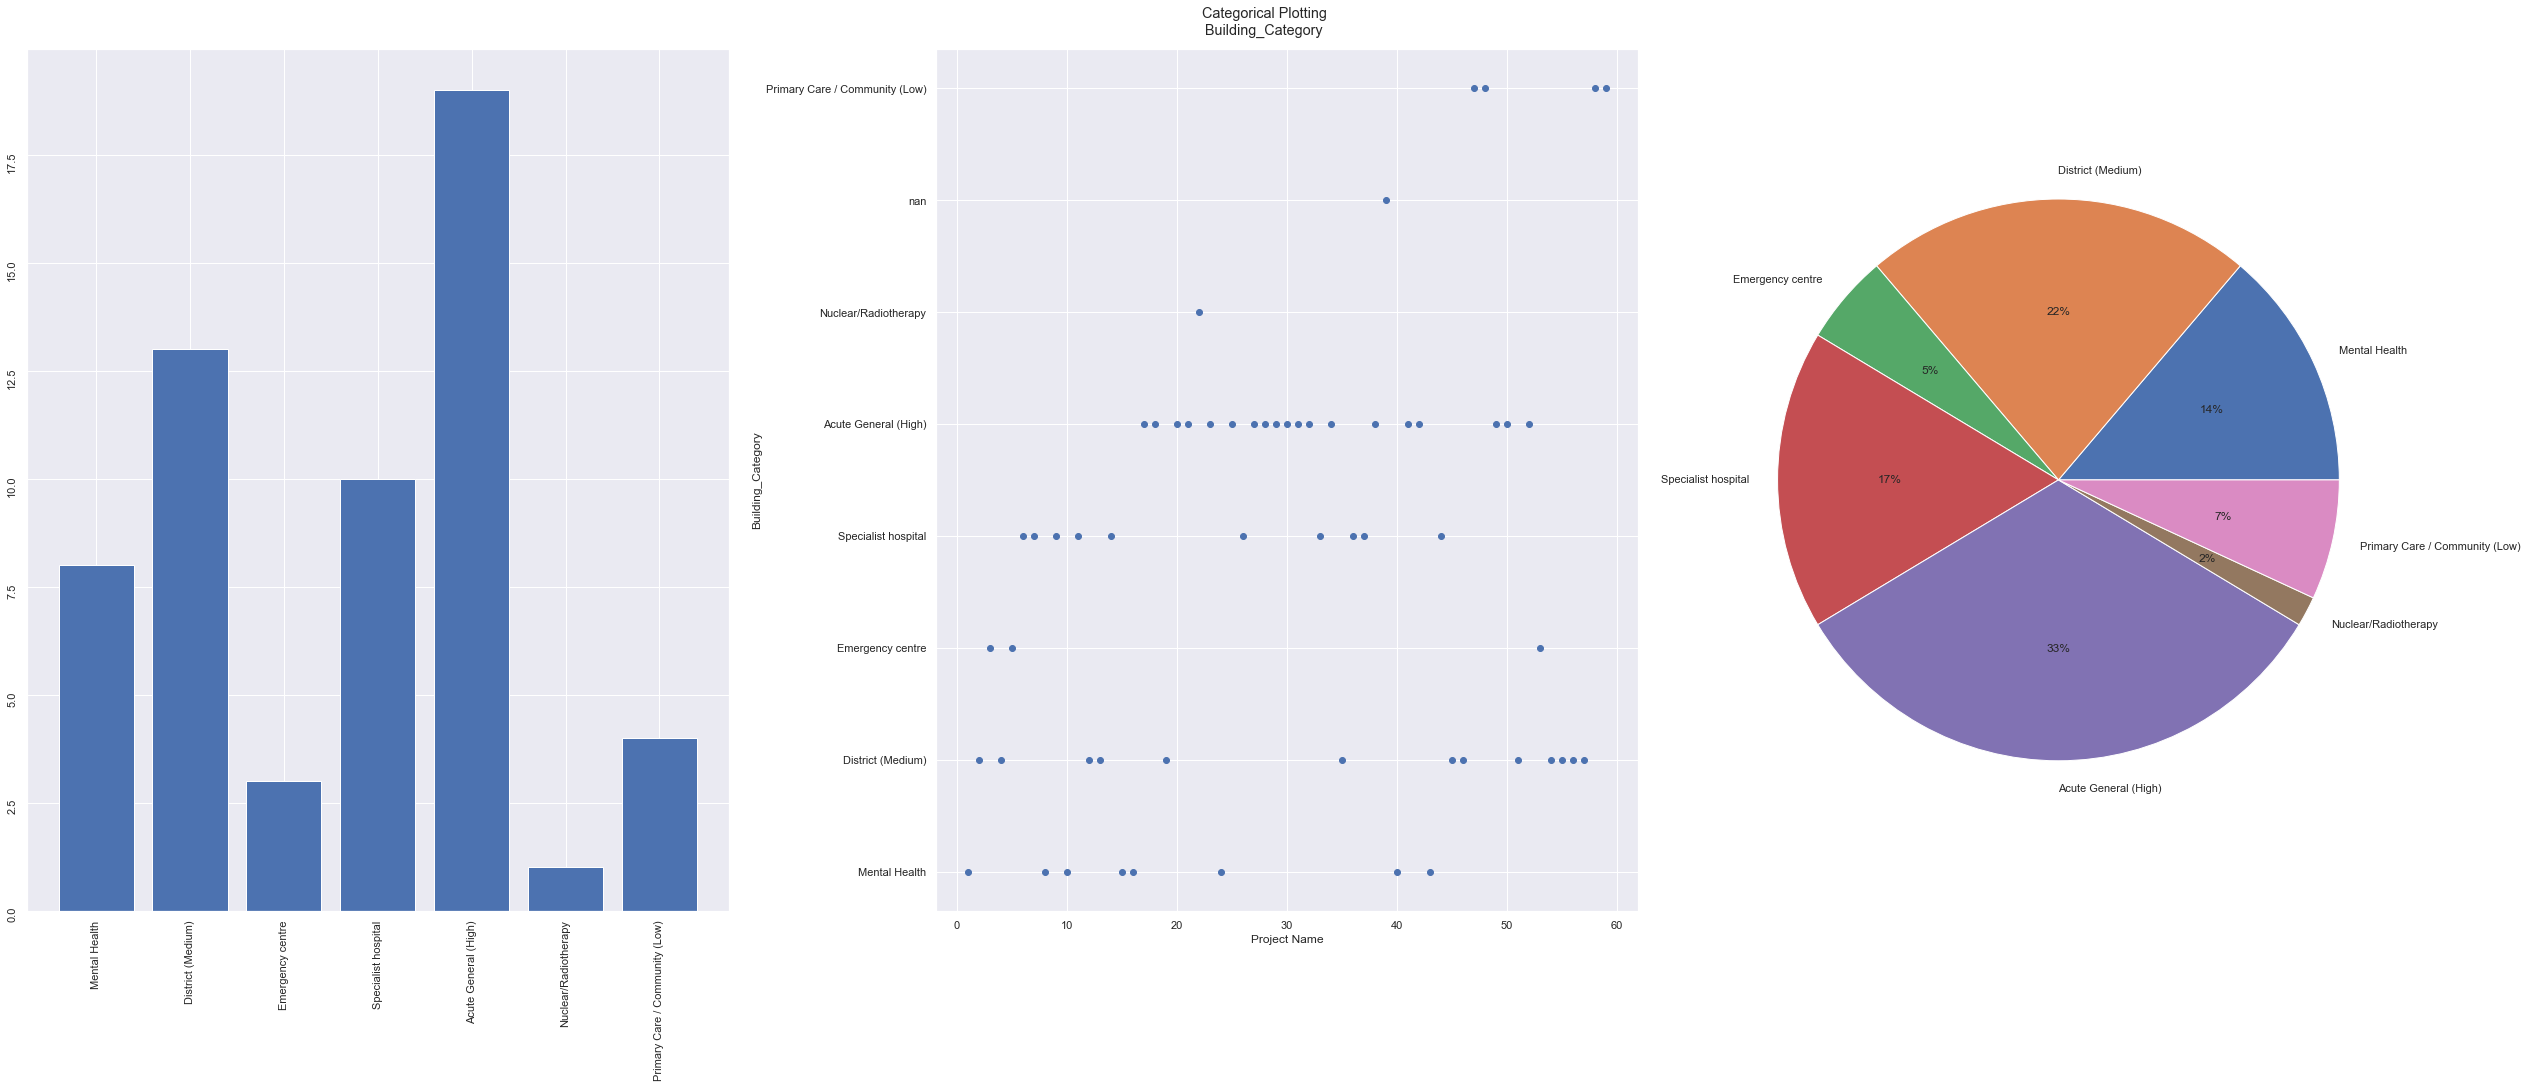

In [40]:
fig, (ax10, ax12, ax31) = plt.subplots(1, 3, figsize = (35, 15), constrained_layout=True)
# bar chart
ax10.bar(key(bc), value(bc))
ax10.tick_params(labelrotation=90)

# scattering plot
x = np.arange(1,60)
y = np.array(list_1(bc))
ax12.scatter(x, y)
ax12.set(xlabel = 'Project Name', ylabel = 'Building_Category')

# pie chart 
labels = key(bc)
nums = value(bc)
ax31.pie(nums, labels = labels, autopct='%.0f%%')

fig.suptitle('Categorical Plotting\nBuilding_Category')

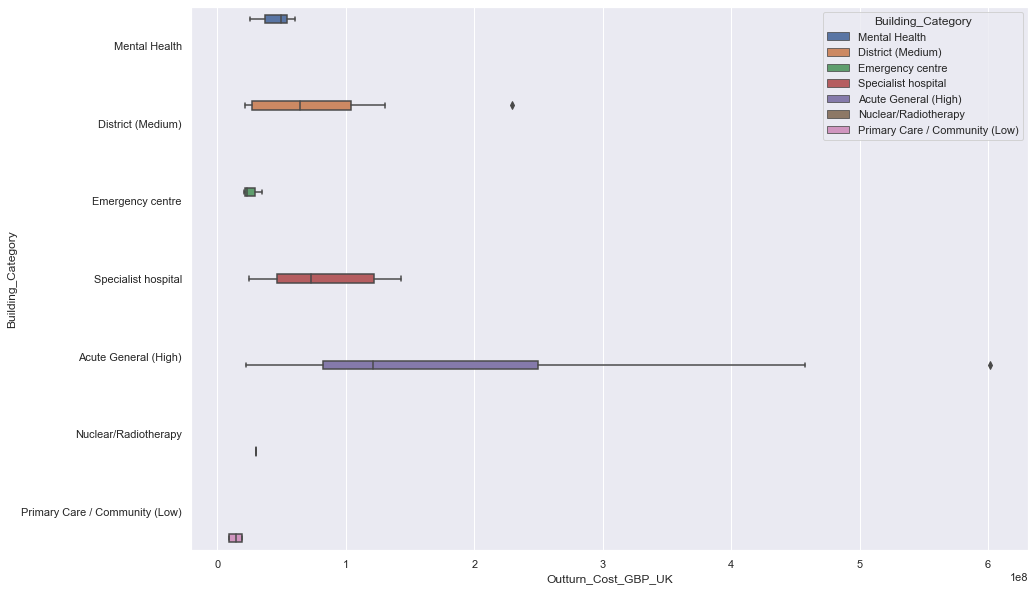

In [44]:
sn.boxplot(y='Building_Category',x='Outturn_Cost_GBP_UK', 
           data=df, hue='Building_Category')
sn.set(rc={'figure.figsize':(15,10)})

Project_Status:

Text(0.5, 0.98, 'Categorical Plotting\nProject_Status')

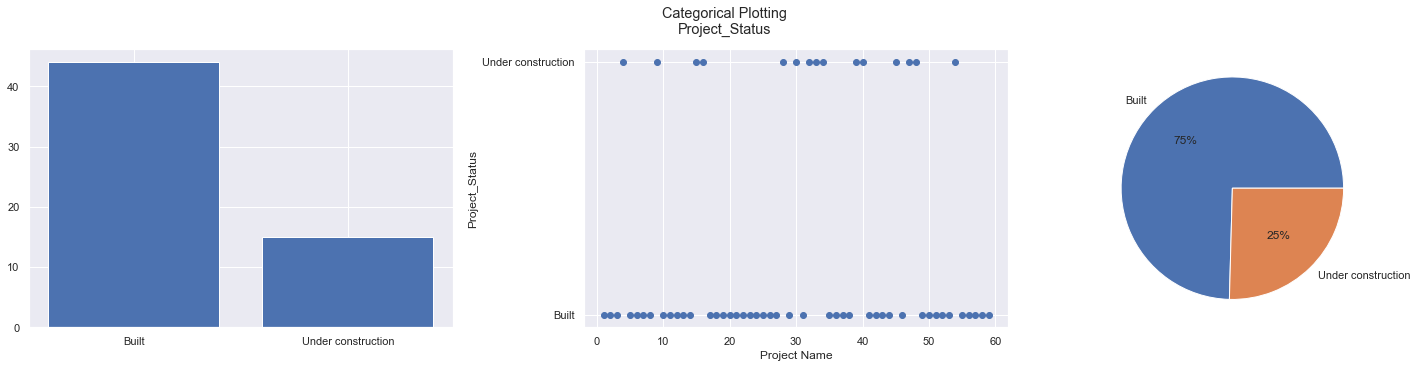

In [46]:
fig, (ax28, ax30, ax31) = plt.subplots(1, 3, figsize = (20, 5),  constrained_layout=True)
# bar chart
ax28.bar(key(ps), value(ps))

# scattering plot
y = np.array(list_1(ps))
ax30.scatter(x, y)
ax30.set(xlabel = 'Project Name', ylabel = 'Project_Status')

# as the data are complete, then only have 2 elements so, 
# pie chart
labels = key(ps)
nums = value(ps)
ax31.pie(nums, labels = labels, autopct='%.0f%%')
fig.suptitle('Categorical Plotting\nProject_Status')

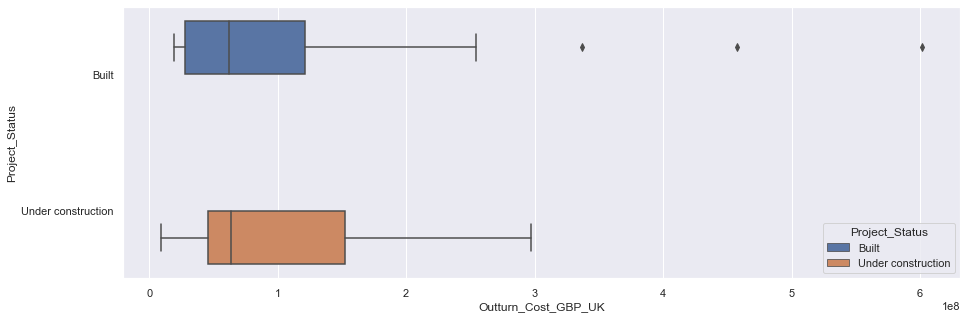

In [54]:
sn.boxplot(y='Project_Status',x='Outturn_Cost_GBP_UK', 
           data=df, hue='Project_Status')
sn.set(rc={'figure.figsize':(15,5)})

Site_for_development:

Text(0.5, 0.98, 'Categorical Plotting\n Site_for_development')

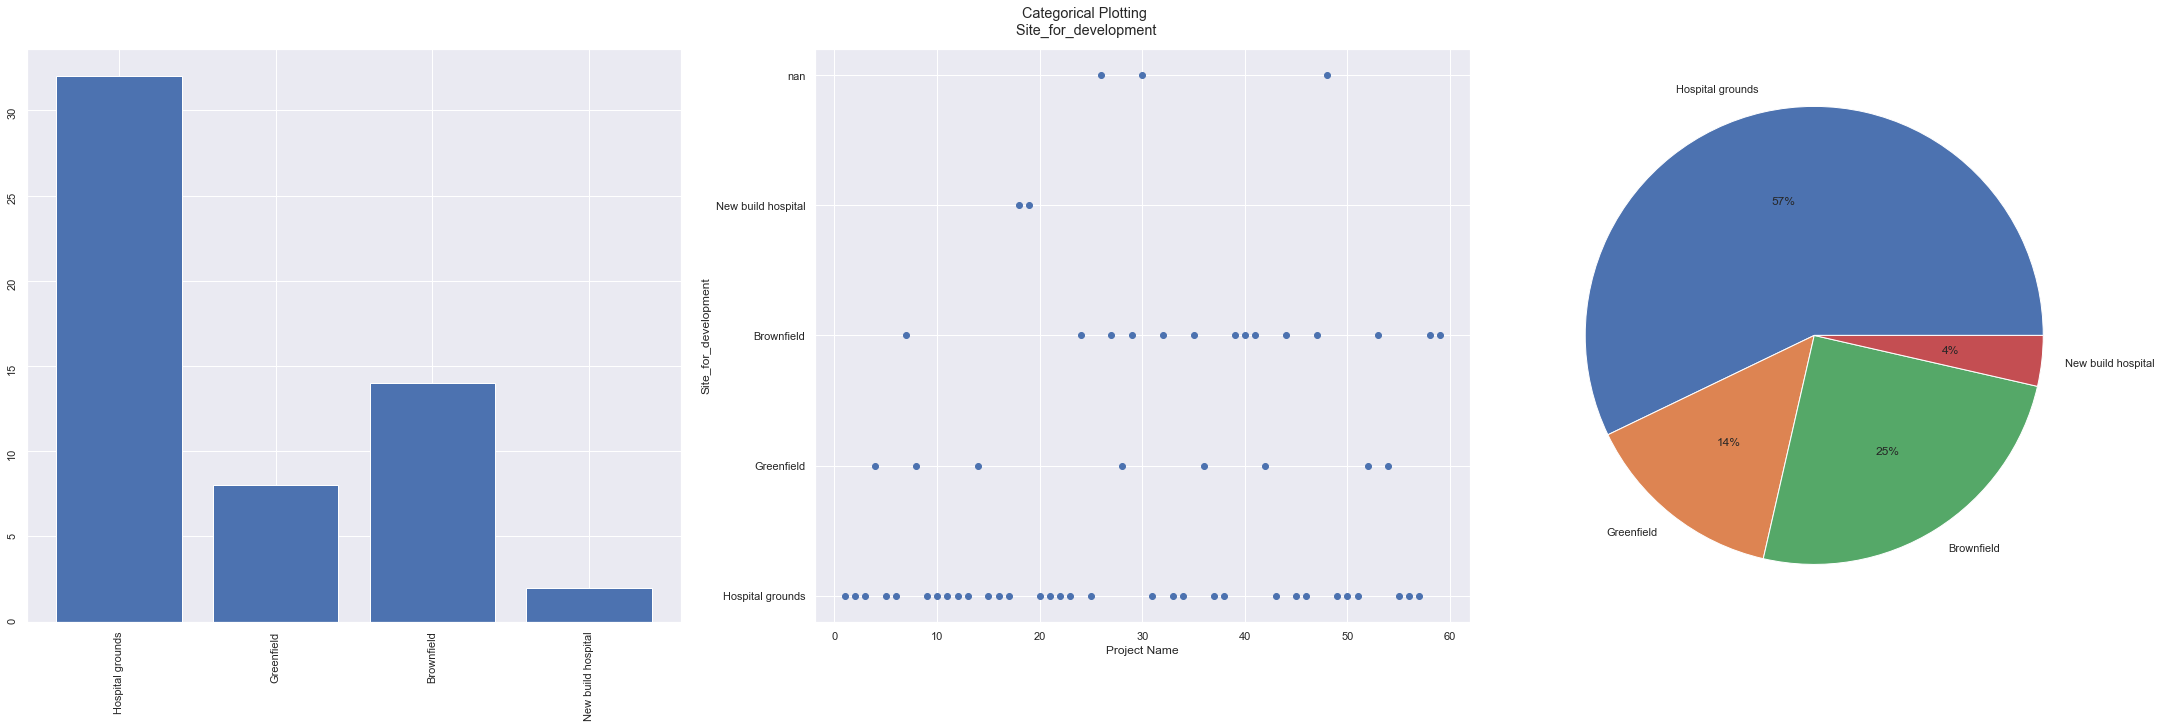

In [55]:
fig, (ax7, ax9, ax31) = plt.subplots(1, 3, figsize = (30, 10), constrained_layout=True)
# bar chart
ax7.bar(key(sd), value(sd))
ax7.tick_params(labelrotation=90)

# linear relation
ax8.plot(key(sd), value(sd))
ax8.tick_params(labelrotation=90) 

# scattering plot
x = np.arange(1,60)
y = np.array(list_1(sd))
ax9.scatter(x, y)
ax9.set(xlabel = 'Project Name', ylabel = 'Site_for_development')

# pie chart 
labels = key(sd)
nums = value(sd)
ax31.pie(nums, labels = labels, autopct='%.0f%%')
fig.suptitle('Categorical Plotting\n Site_for_development')

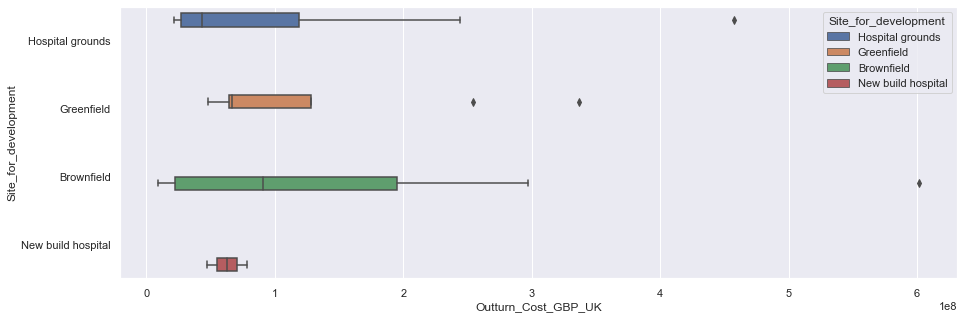

In [58]:
sn.boxplot(y='Site_for_development',x='Outturn_Cost_GBP_UK', 
           data=df, hue='Site_for_development')
sn.set(rc={'figure.figsize':(15,5)})

Source_of_costs:

Text(0.5, 0.98, 'Categorical Plotting\n Source_of_costs')

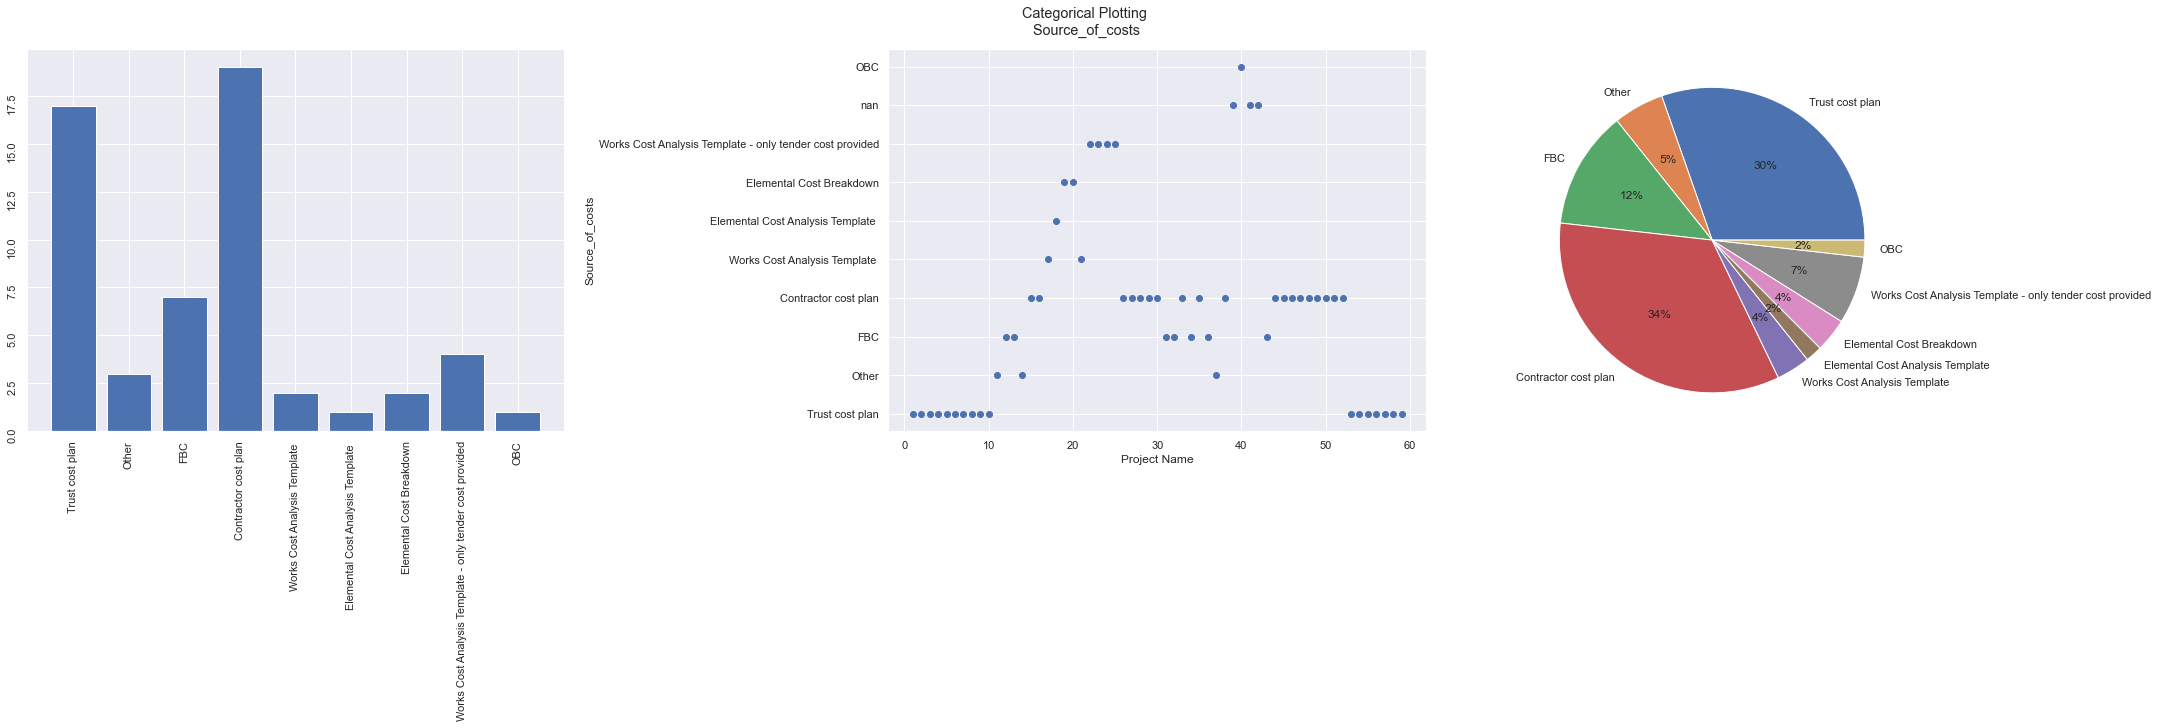

In [65]:
fig, (ax7, ax9, ax31) = plt.subplots(1, 3, figsize = (30, 10), constrained_layout=True)
# bar chart
ax7.bar(key(sc), value(sc))
ax7.tick_params(labelrotation=90)

# scattering plot
x = np.arange(1,60)
y = np.array(list_1(sc))
ax9.scatter(x, y)
ax9.set(xlabel = 'Project Name', ylabel = 'Source_of_costs')

# pie chart 
labels = key(sc)
nums = value(sc)
ax31.pie(nums, labels = labels, autopct='%.0f%%')
fig.suptitle('Categorical Plotting\n Source_of_costs')

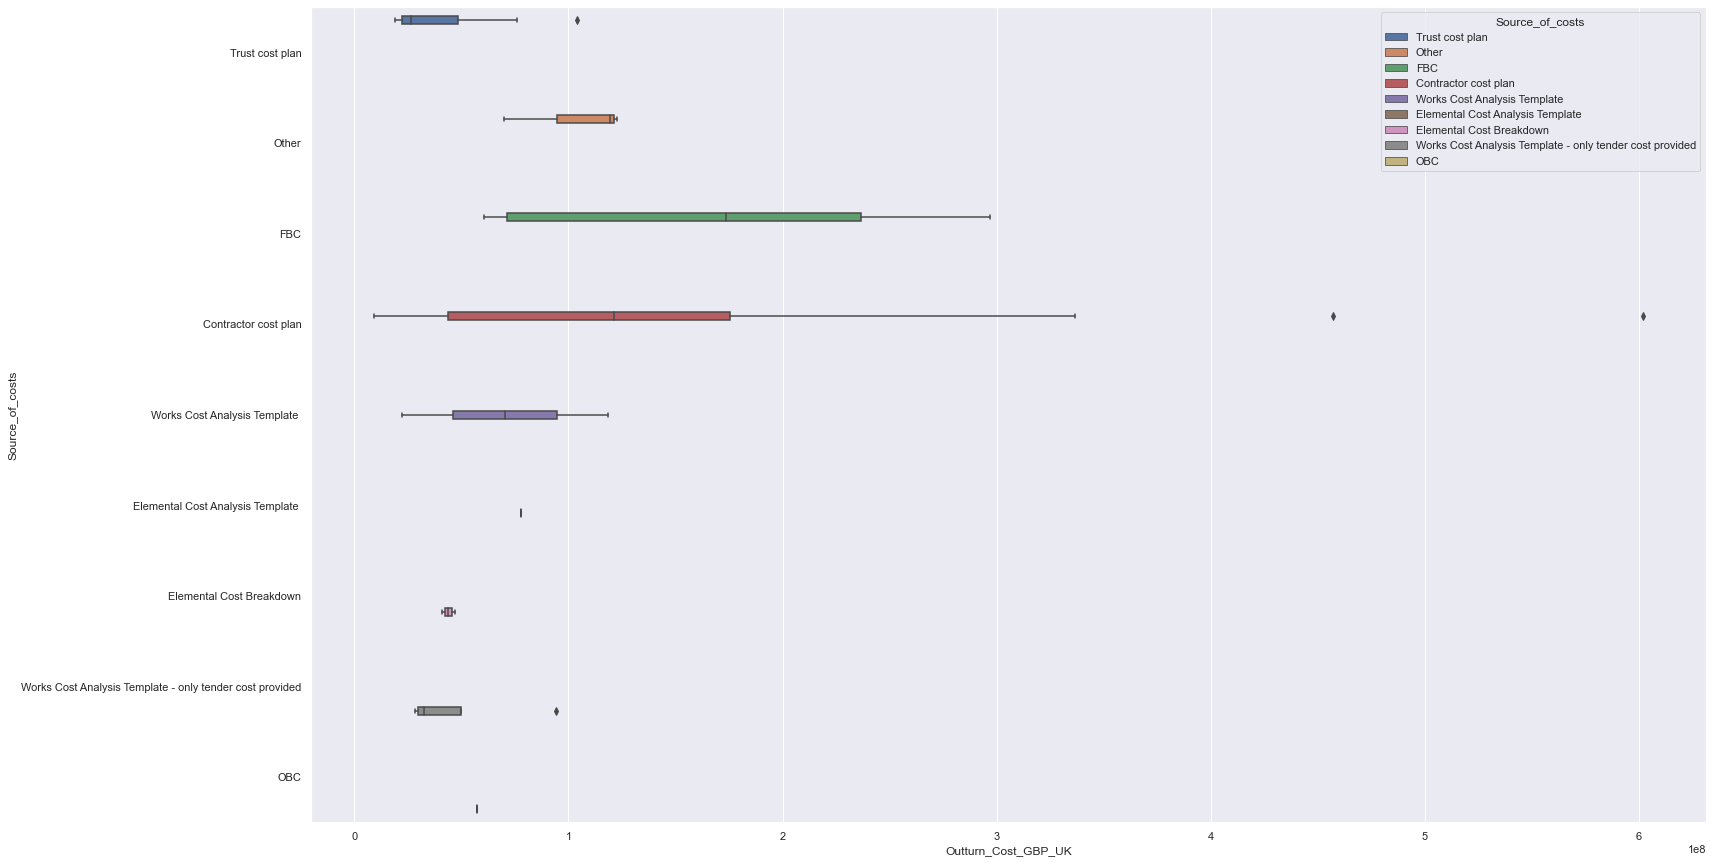

In [71]:
sn.boxplot(y='Source_of_costs',x='Outturn_Cost_GBP_UK', 
           data=df, hue='Source_of_costs')
sn.set(rc={'figure.figsize':(25,25)})

# 3. Preprocessing for ML

In [91]:
df = pd.read_excel('IPA.xlsx')
df = df.drop(columns=['Footprint_m2','Modern_Methods_of_Construction_type','Type_of_energy_centre','Primary_heat_source','Cooling_system','Ventilation','Inpatient_Beds%_Singles'])

In [92]:
# drop the projects without absolute duration day 
# delete the 'project name' column
df = df.dropna(subset=['Absolute_Duration_day'])
dfc = df.drop(columns = ['Organisation/Role_Completing_Template'])

# 3.1 Pairplots

/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoy

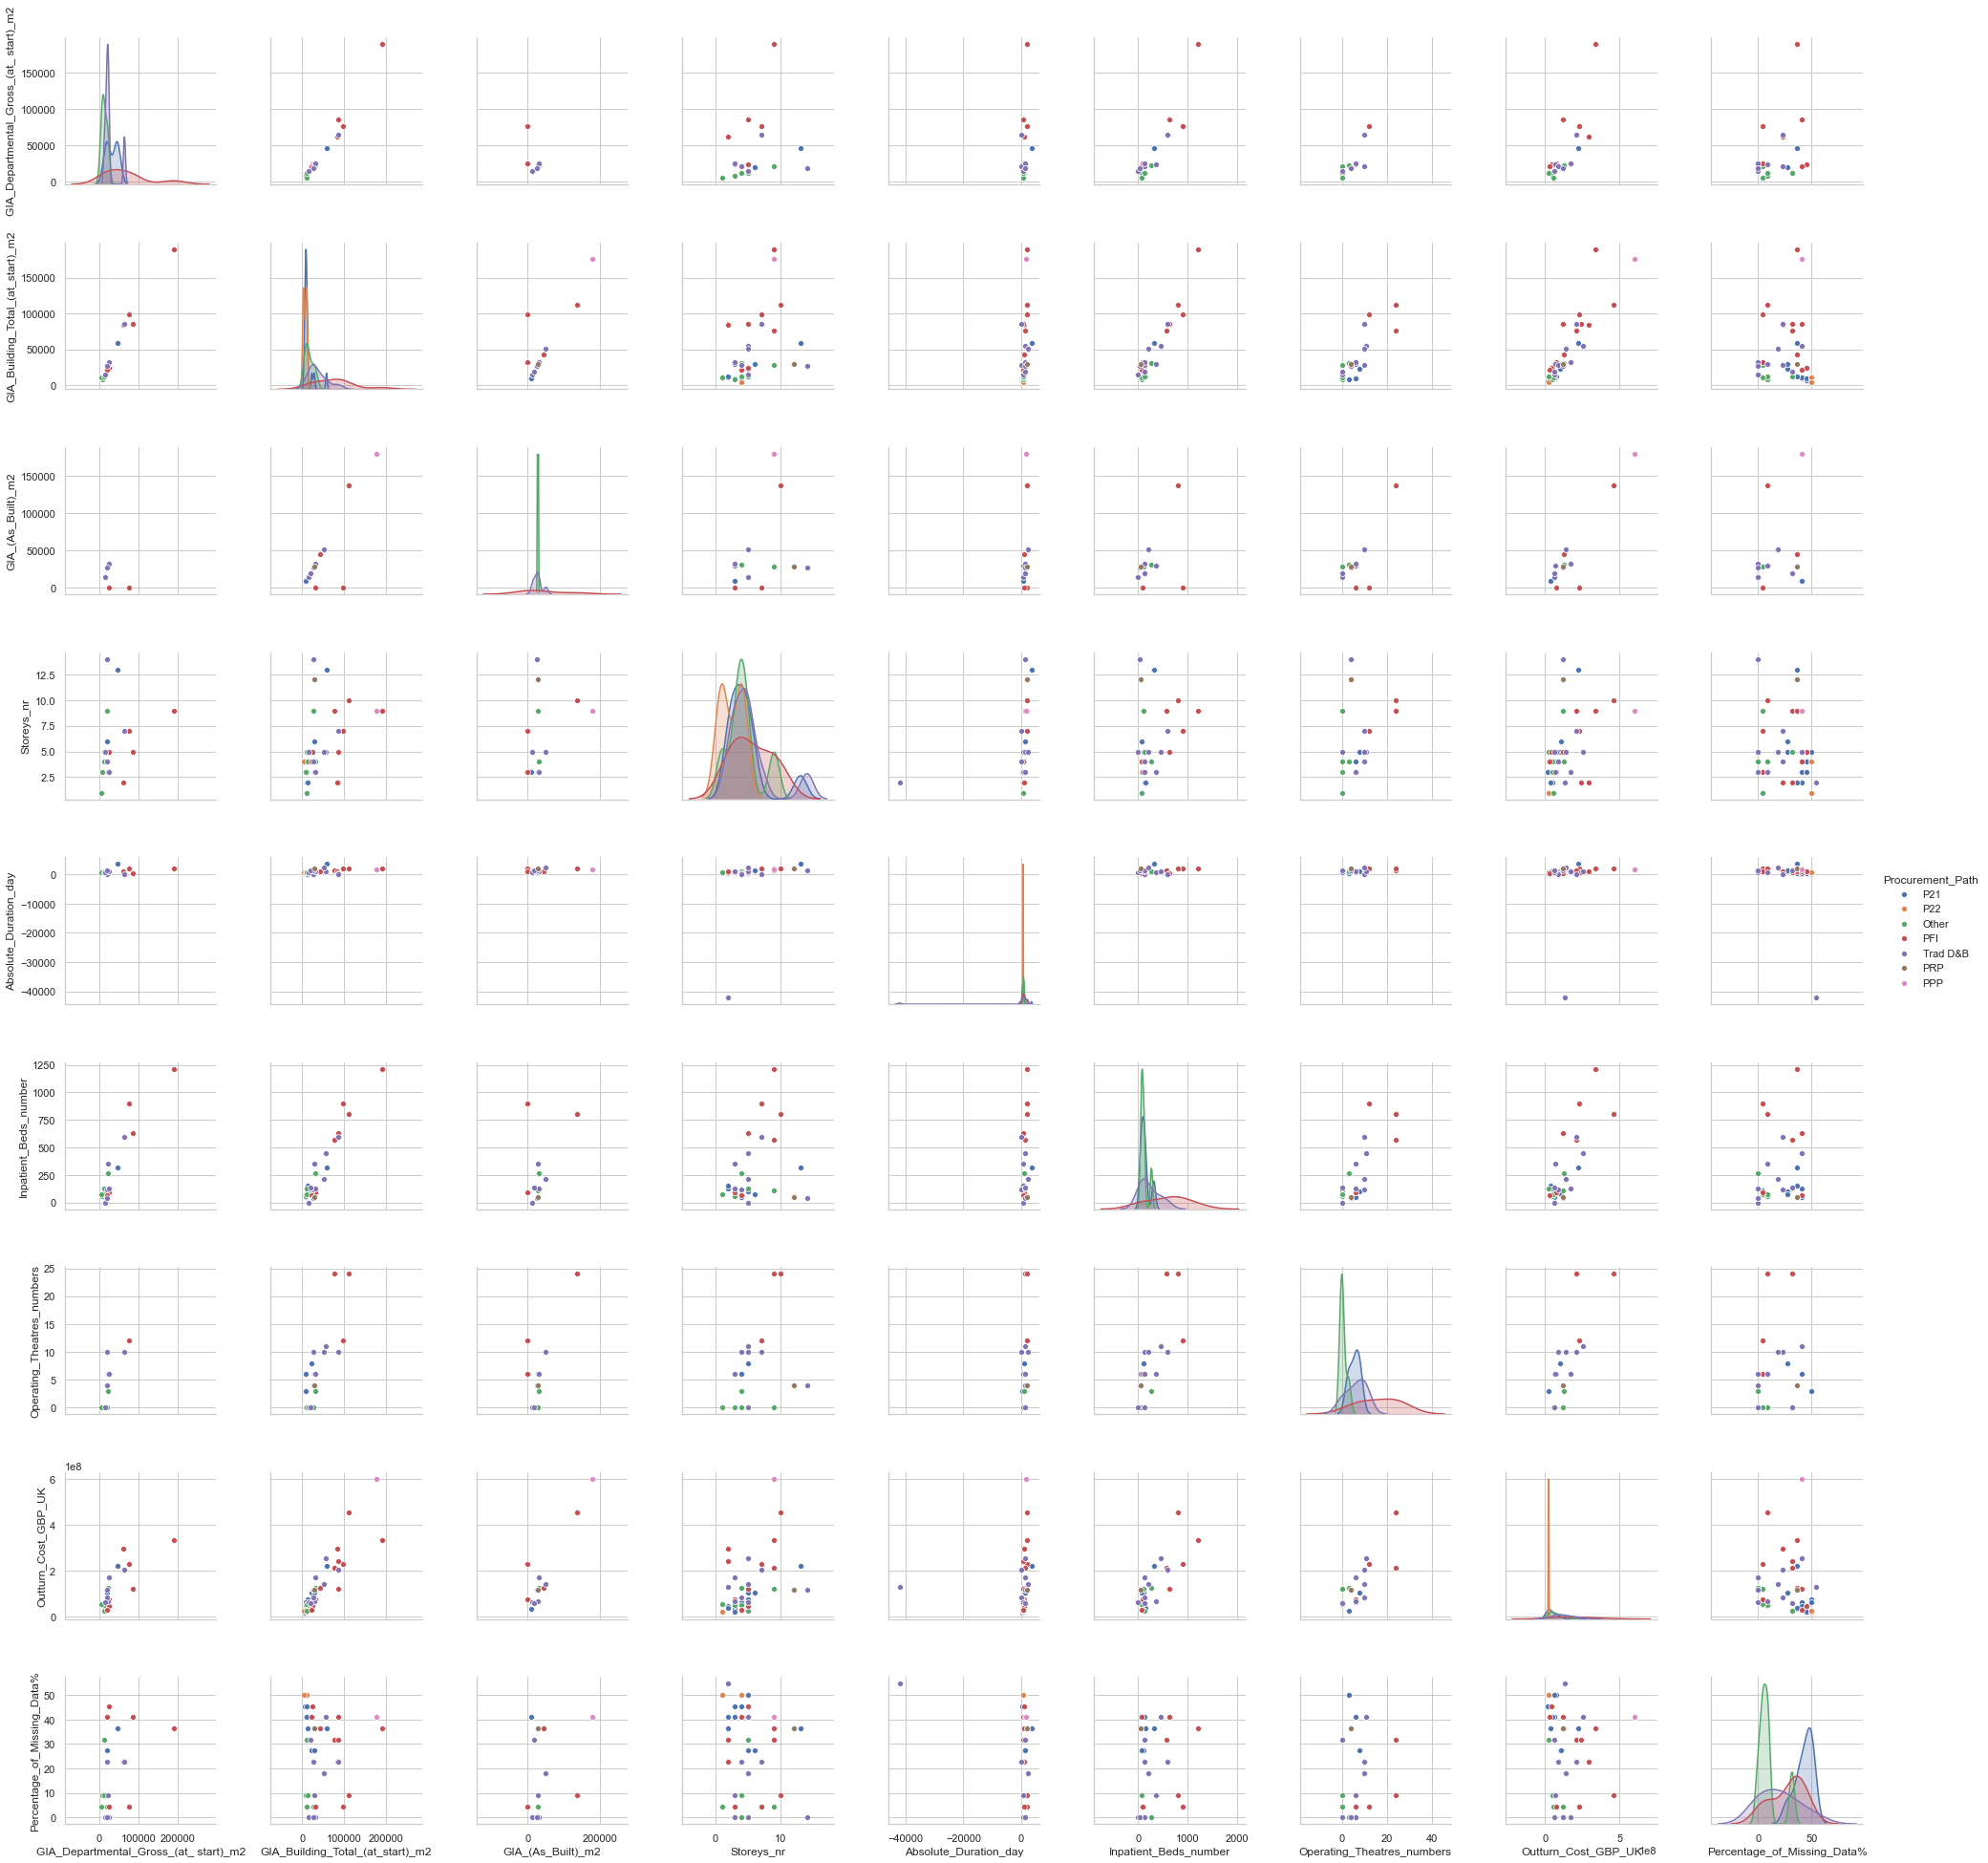

In [76]:
# plotting a scatter matrix wrt Procurement_Path:
sn.set_style("whitegrid");
sn.pairplot(dfc, hue = "Procurement_Path", size = 3);
plt.show()

/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoy

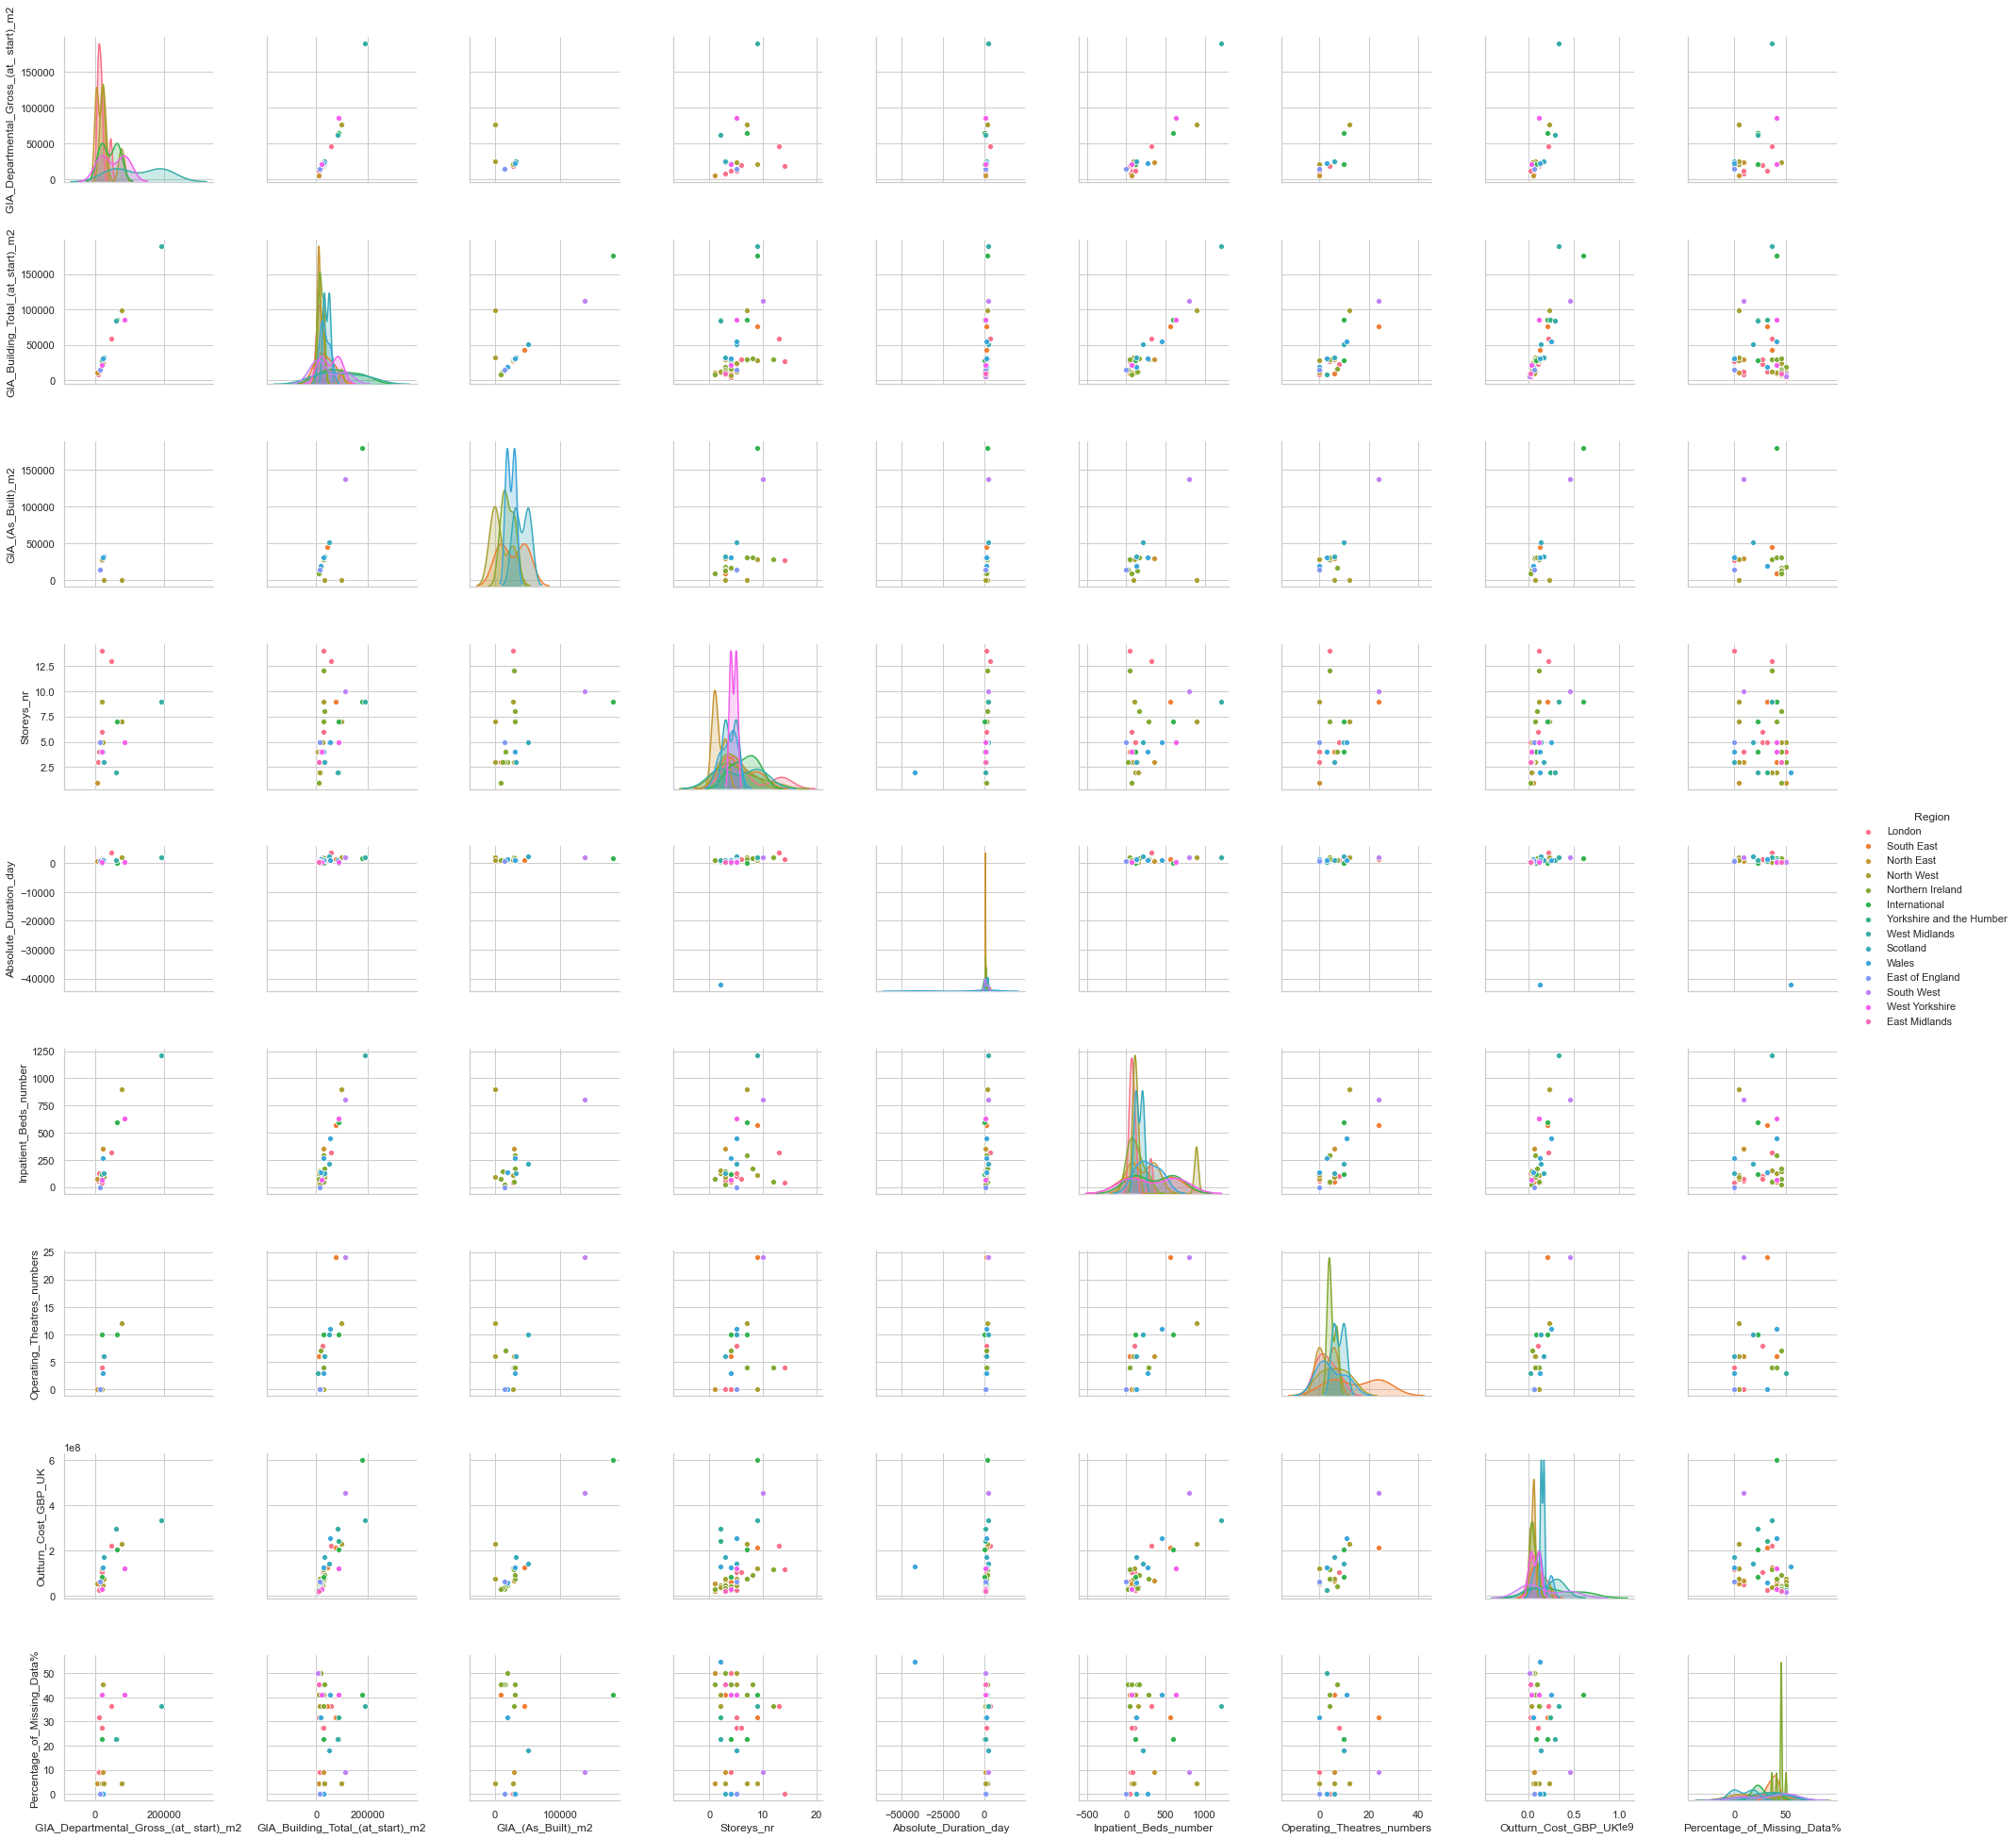

In [77]:
# plotting a scatter matrix wrt Region
sn.set_style("whitegrid");
sn.pairplot(dfc, hue = "Region", size = 3);
plt.show()

/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.


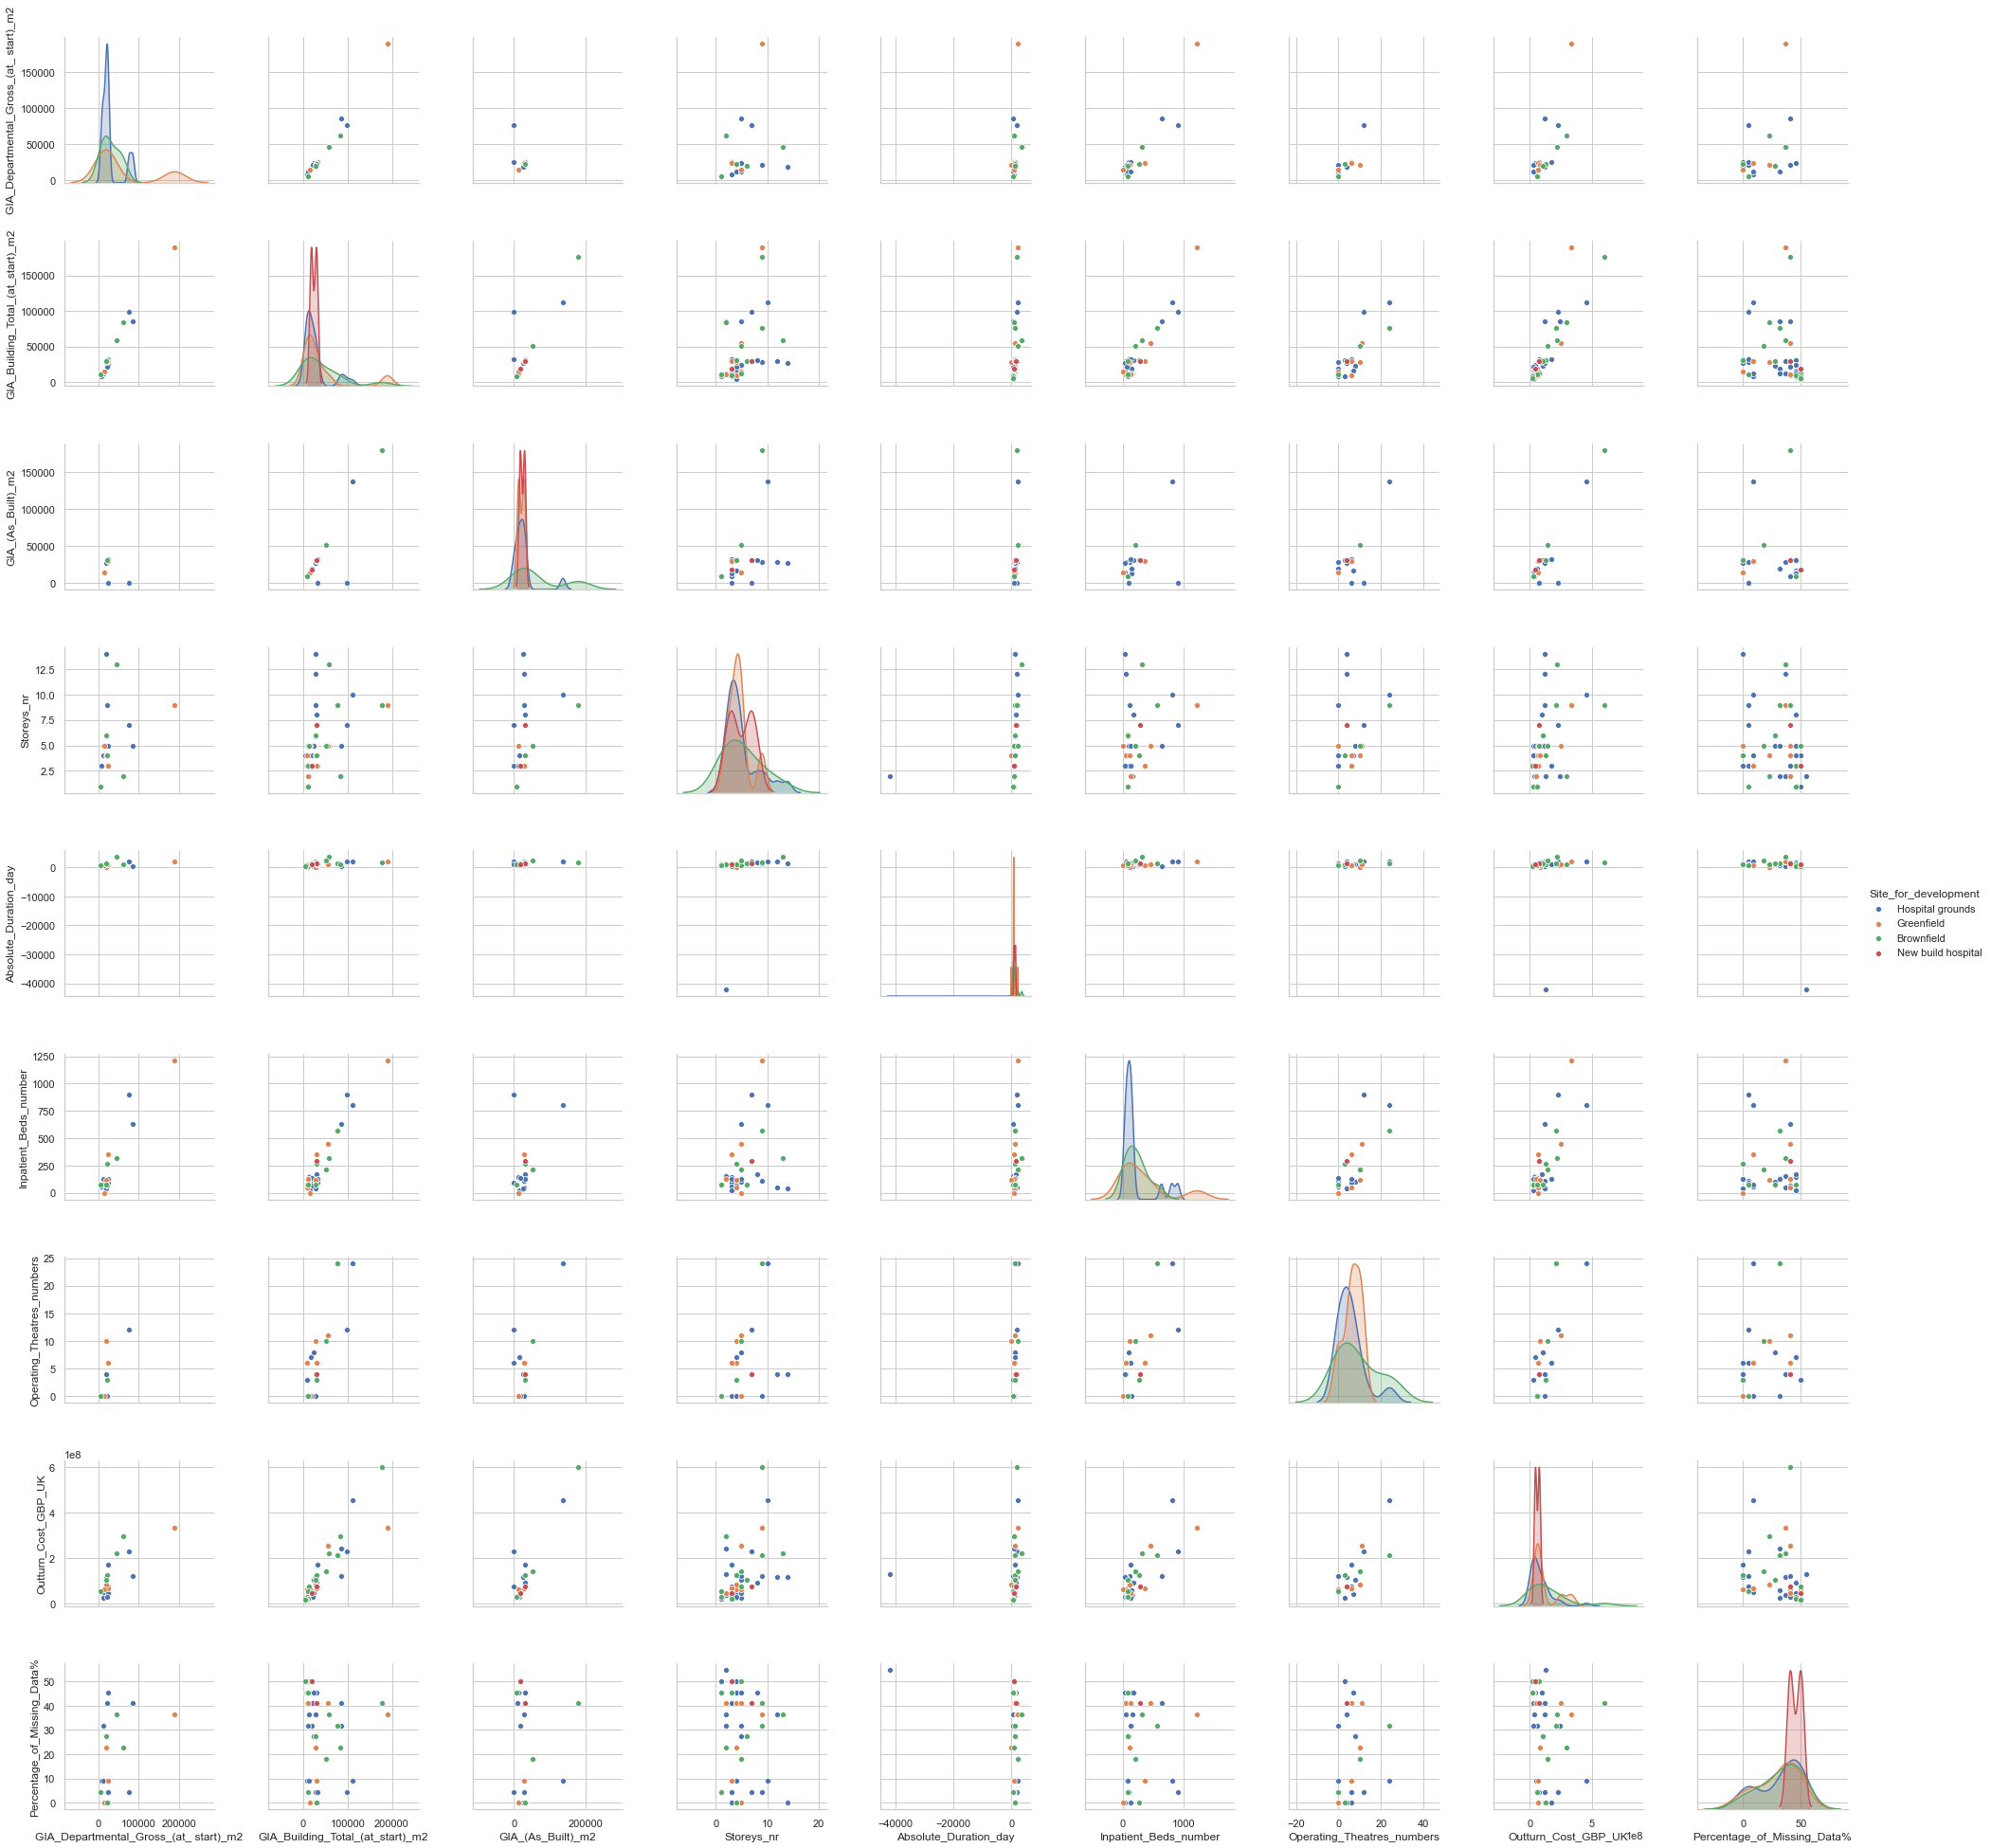

In [78]:
# plotting a scatter matrix wrt Site_for_development
sn.set_style("whitegrid");
sn.pairplot(dfc, hue = "Site_for_development", size = 3);
plt.show()

/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.


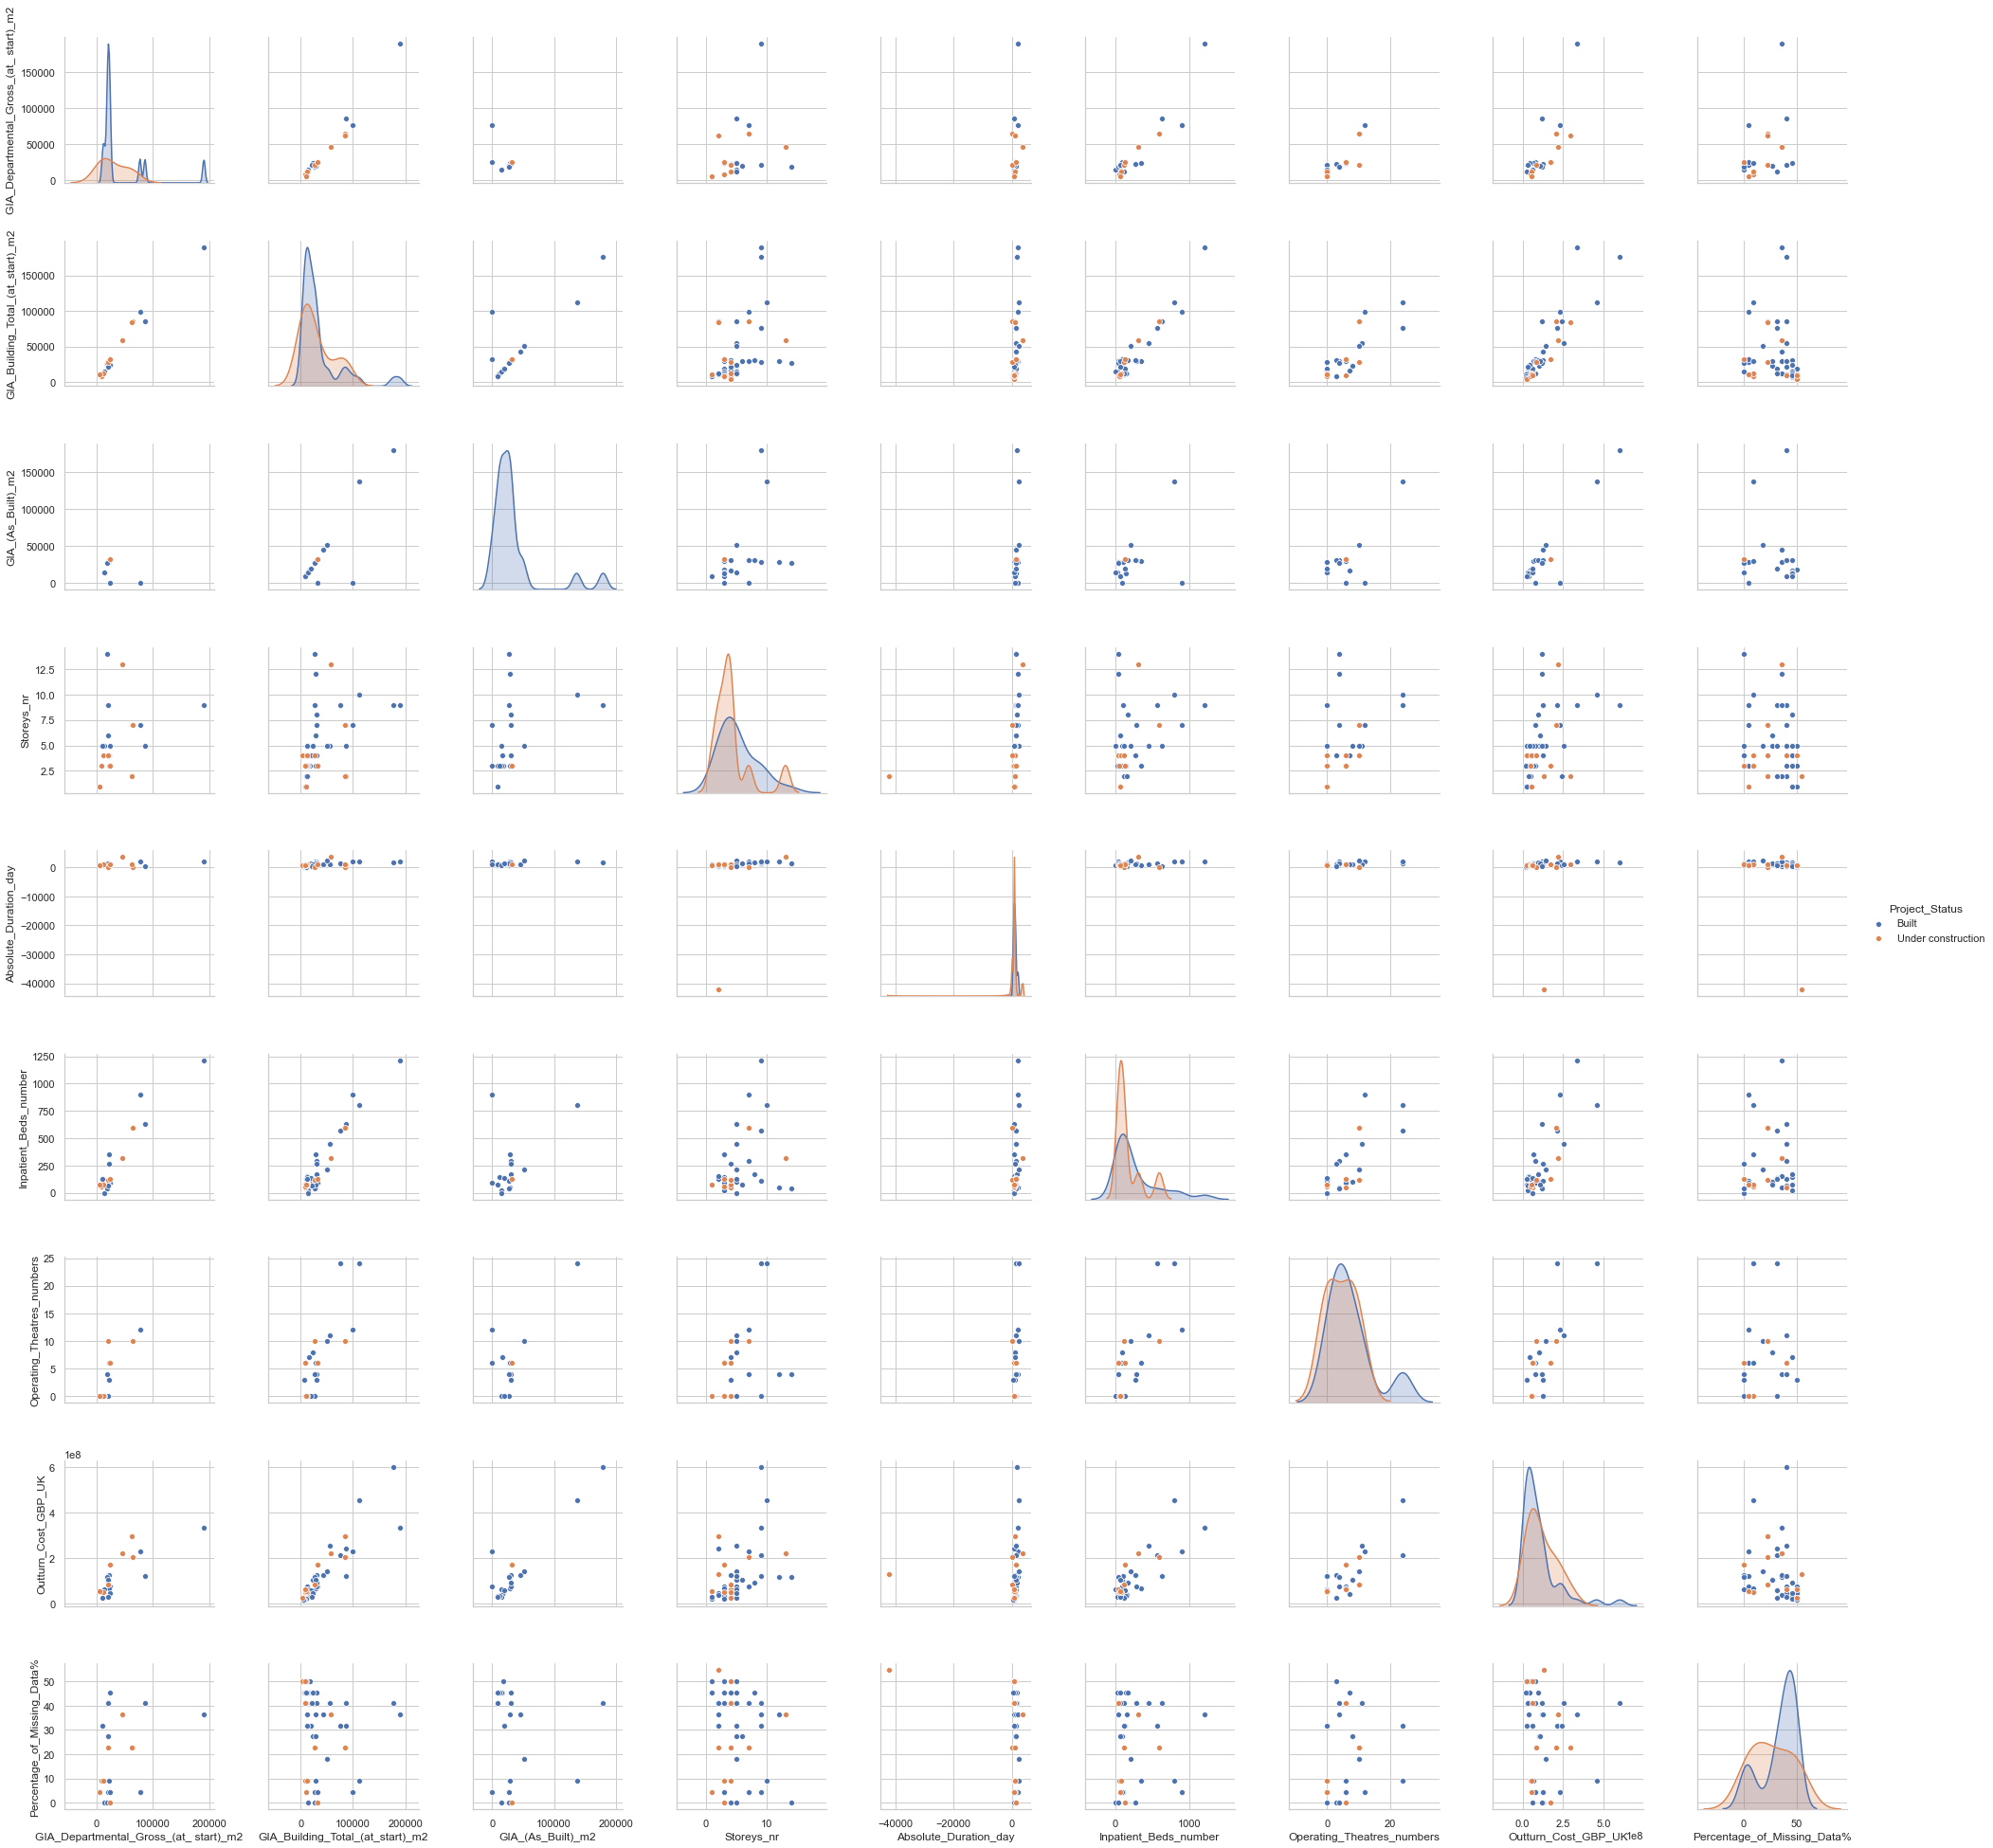

In [80]:
# plotting a scatter matrix wrt Project_Status
sn.set_style("whitegrid");
sn.pairplot(dfc, hue = "Project_Status", size = 3);
plt.show()

# 3.2  Multicollinearity 

In [93]:
# select out the numerical data for minimising multicollinearity 
dfcp = dfc._get_numeric_data()

Numerical Data only:

Text(0.5, 1.0, 'pearson correlation')

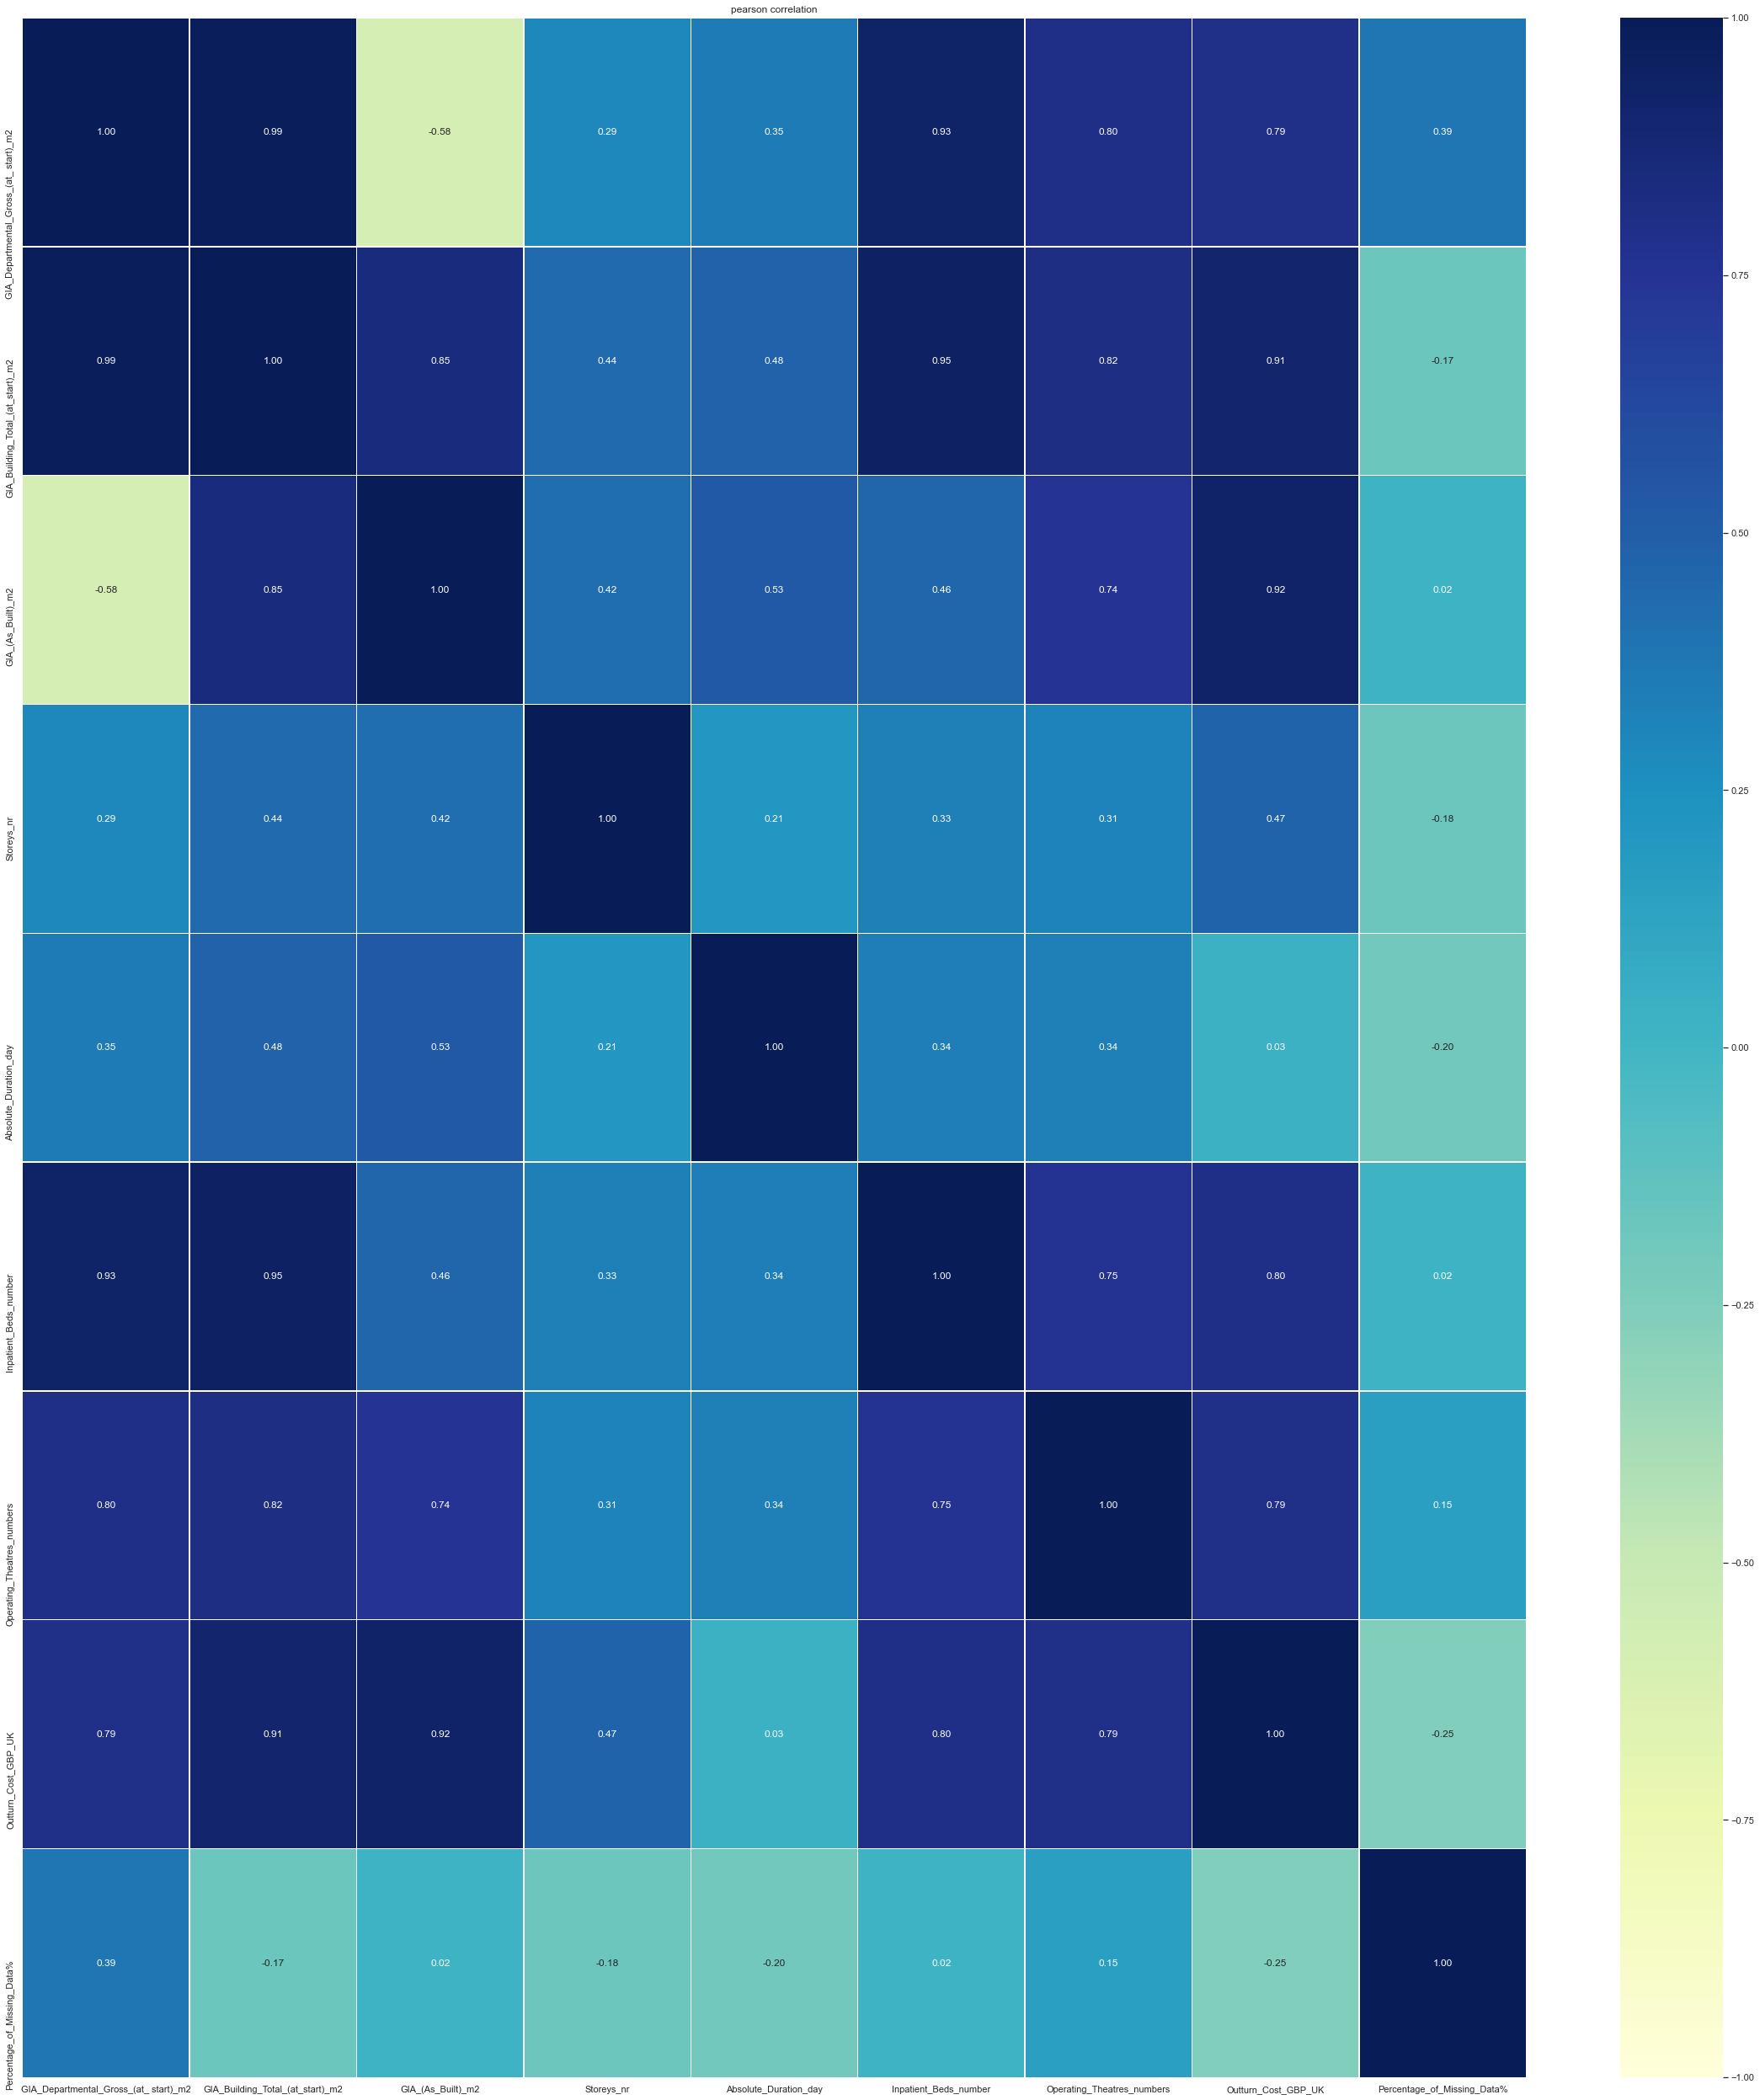

In [94]:
#looking for multicollinearity without scalering
#having two very correlated variables will introduce bias into the model
corr_matrix = dfcp.corr(method="pearson")
sn.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

Melting Multicollinearity By Using Centred Data:

Text(0.5, 1.0, 'pearson correlation 1')

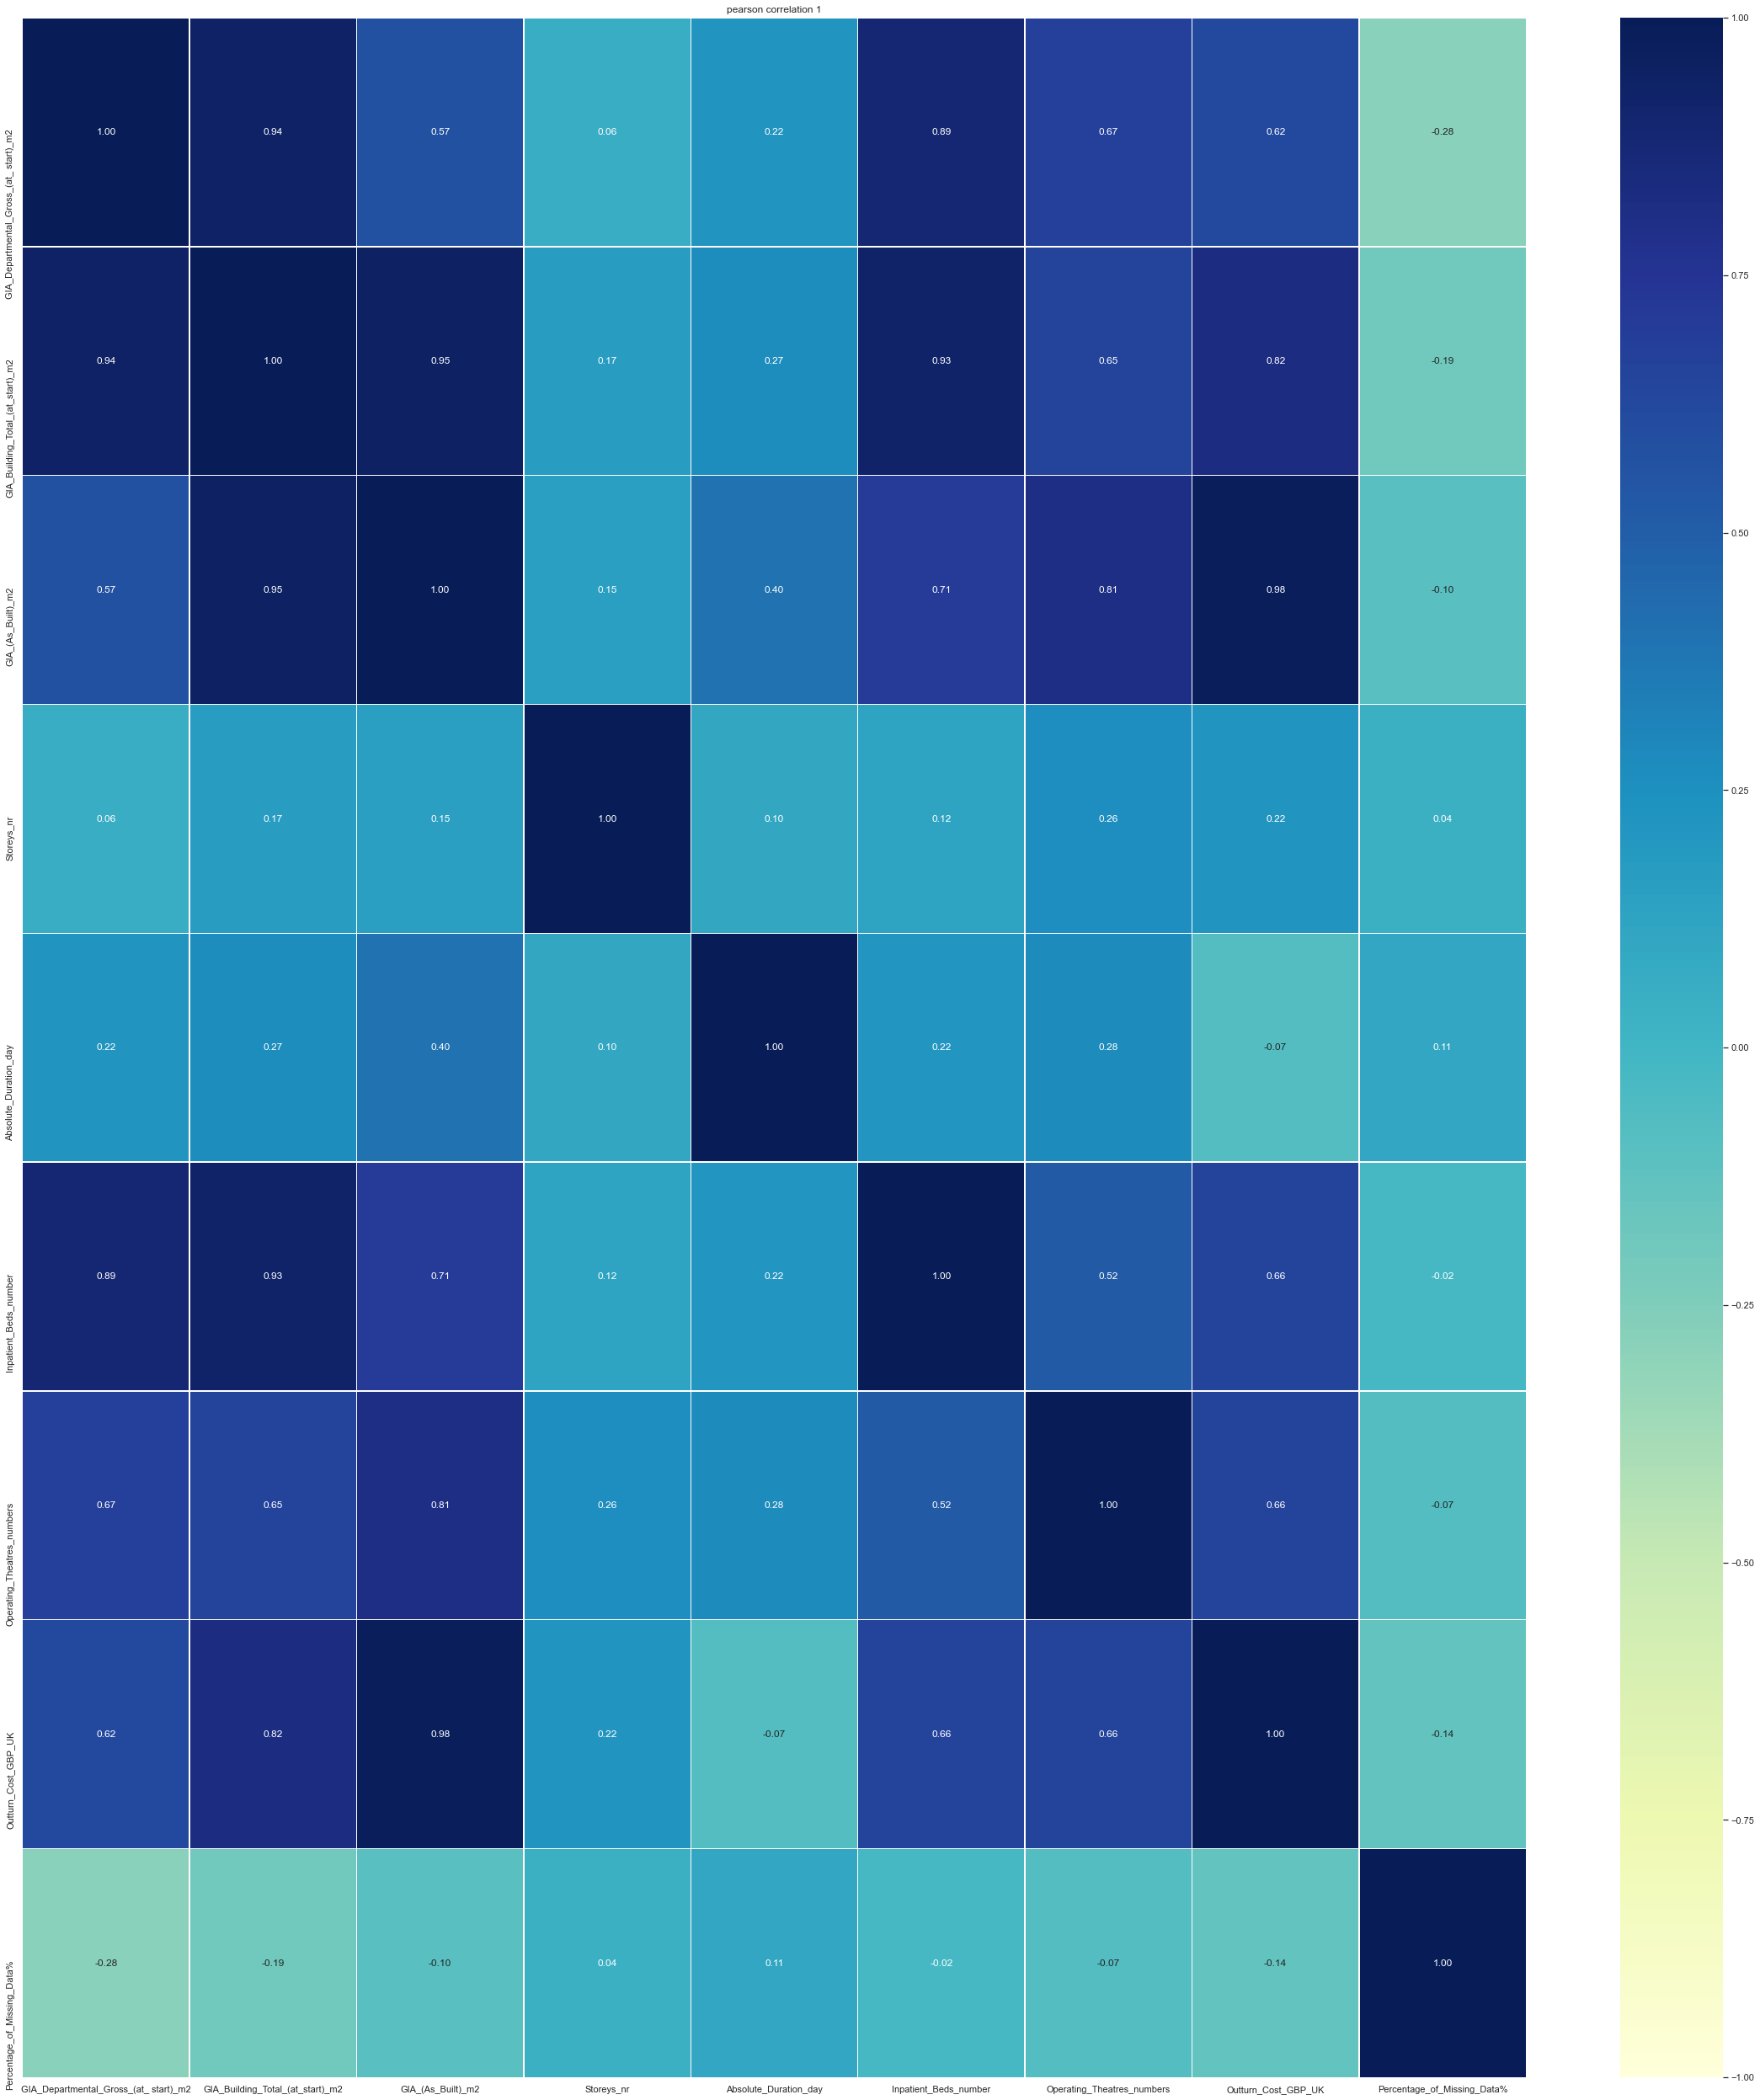

In [95]:
#looking for multicollinearity 
#centred data by dividing each value by its mean
for x in dfcp.columns:
    dfcp[x] = (dfcp[x] - dfcp[x].mean()).abs()

# a revised pearson correlation graph
corr_matrix = dfcp.corr(method="pearson")
sn.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation Centred")

Melting Multicollinearity By Taking LOG to each data:

Text(0.5, 1.0, 'pearson correlation 2')

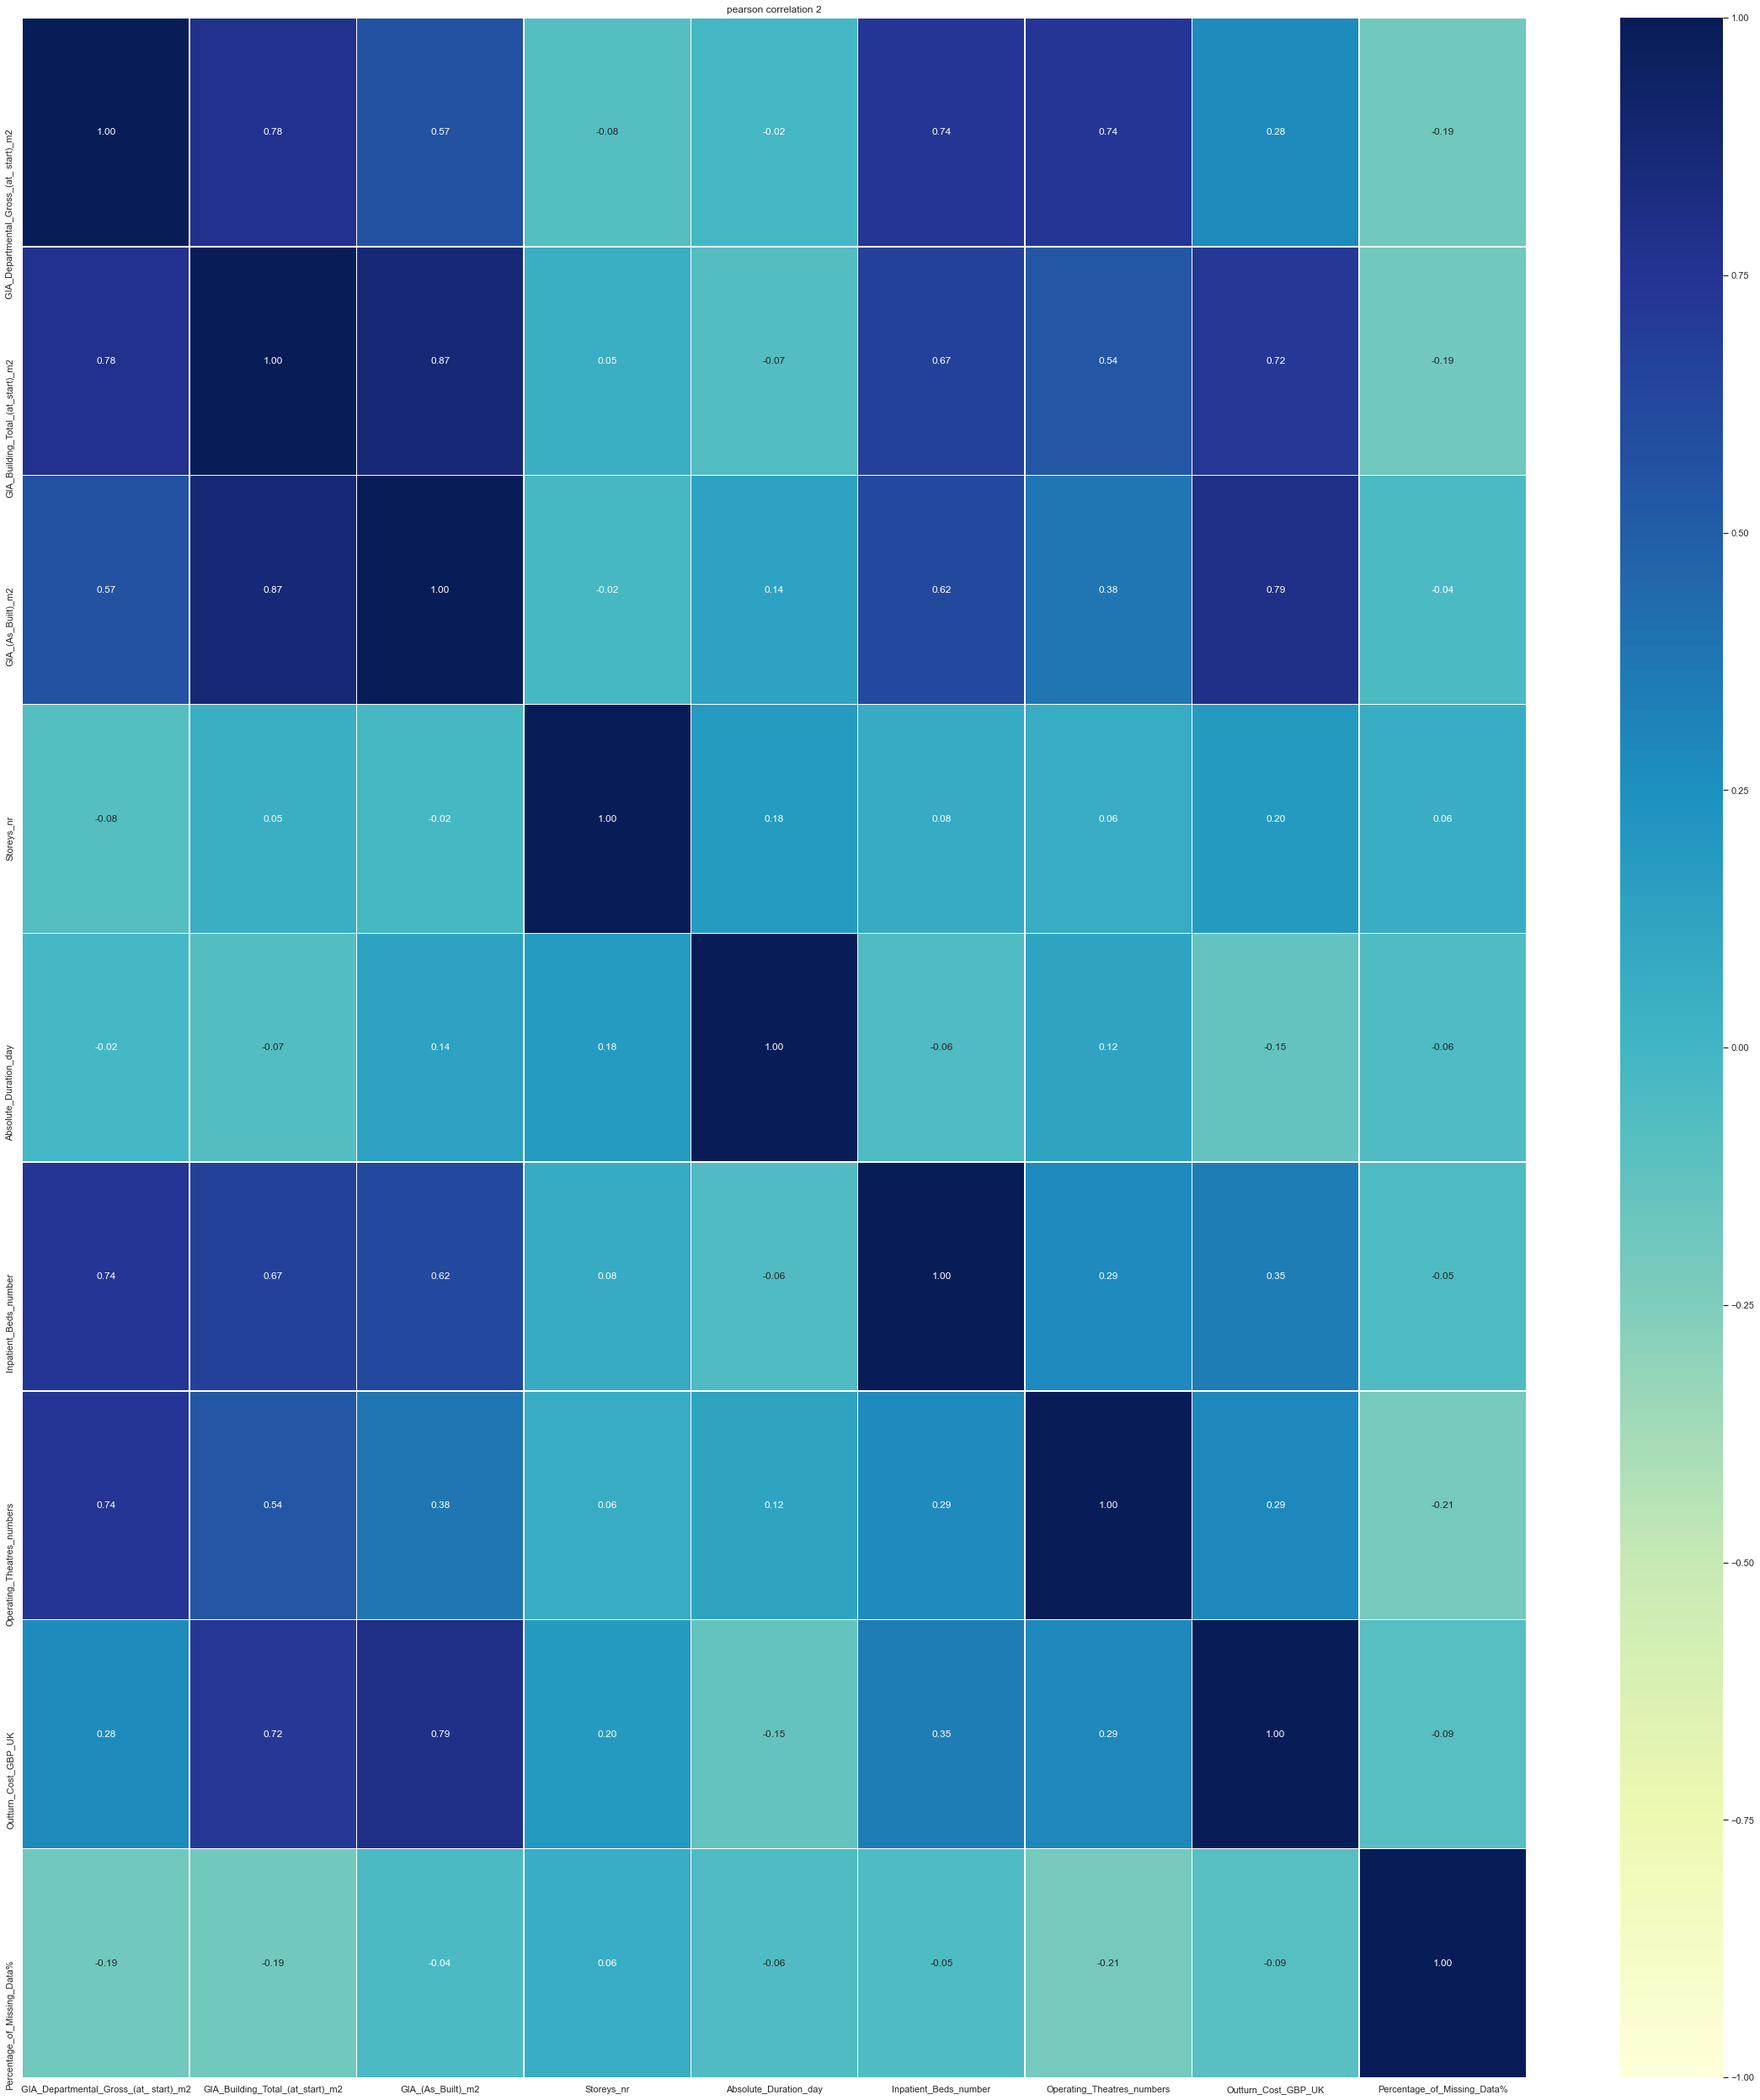

In [90]:
# logarithm on base 10 value of each variale 
dfcp1 = dfc._get_numeric_data()
for x in dfcp1.columns:
    dfcp1[x] = np.log10(dfcp1[x])

# a revised pearson correlation graph
corr_matrix = dfcp1.corr(method="pearson")
sn.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation LOG")

In [106]:
# Variables Selection:
# Step2: Delete 'GIA_Departmental_Gross_(at_ start)_m2' and 'GIA_(As_Built)_m2', 'Inpatient_Beds_number ' due to high correlation
df = pd.read_excel('IPA.xlsx')
df = df.drop(columns=['Footprint_m2','Modern_Methods_of_Construction_type','Type_of_energy_centre',
                      'Primary_heat_source','Cooling_system','Ventilation','Inpatient_Beds%_Singles',
                      'Organisation/Role_Completing_Template','GIA_Departmental_Gross_(at_ start)_m2',
                     'GIA_(As_Built)_m2', 'Inpatient_Beds_number'])

In [107]:
# one-hot encoding to make categorical data numerical
# drop_first=true is used to break colliarity, as otherwise the linear model will be off
dfn = pd.get_dummies(df,drop_first=True)

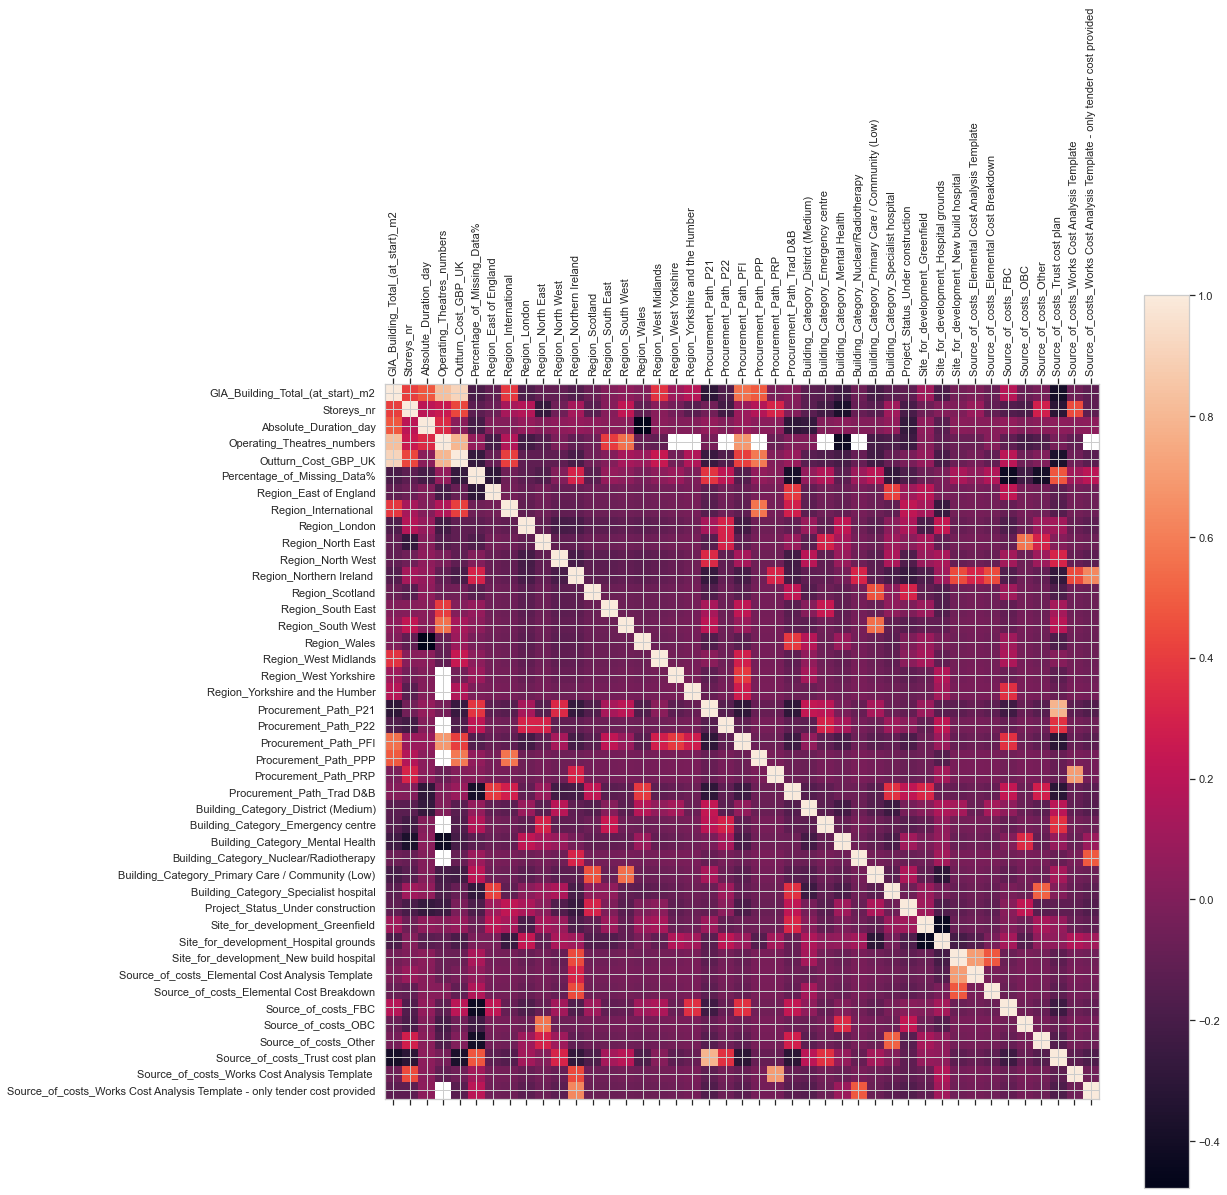

In [108]:
plt.matshow(dfn.corr())
plt.xticks(range(len(dfn.columns)), dfn.columns, rotation=90)
plt.yticks(range(len(dfn.columns)), dfn.columns)
plt.colorbar()
plt.show()

# 4. Model Selection:

In [144]:
# count how many missing data for each numerical variables
count = dfn.iloc[:, : 5].isna().sum()
count
# 'Footprint_m2' has the most ungiven data

GIA_Building_Total_(at_start)_m2     1
Storeys_nr                           9
Operating_Theatres_numbers          33
Outturn_Cost_GBP_UK                  0
Percentage_of_Missing_Data%          0
dtype: int64

# 4.1Outturn_Cost_GBP_UK :

In [368]:
# open file 
df = pd.read_excel('IPA.xlsx')
df = df.drop(columns=['Footprint_m2','Modern_Methods_of_Construction_type','Type_of_energy_centre',
                      'Primary_heat_source','Cooling_system','Ventilation','Inpatient_Beds%_Singles',
                      'Organisation/Role_Completing_Template','GIA_Departmental_Gross_(at_ start)_m2',
                     'GIA_(As_Built)_m2', 'Inpatient_Beds_number','Absolute_Duration_day',
                     'Percentage_of_Missing_Data%'])
df = df.dropna(subset=['Outturn_Cost_GBP_UK'])
df.shape

(59, 10)

In [369]:
# change unit of outturn_cost_gbp_uk 
df['Outturn_Cost_GBP_UK'] = df['Outturn_Cost_GBP_UK'] / (10**7)

In [370]:
# one-hot encoding to make categorical data numerical
# drop_first=true is used to break colliarity, as otherwise the linear model will be off
dfn = pd.get_dummies(df,drop_first=True)
dfn.shape

(59, 41)

In [371]:
# as taking log to each data gives better multicollinearity
# use log data for comparing models
for x in dfn.iloc[:, : 4].columns:
    dfn[x] = np.log10(dfn[x])

/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


In [372]:
# Replacing infinite with nan
dfn.replace([np.inf, -np.inf], np.nan, inplace=True)

In [373]:
# imputate by using median method
dfn['Storeys_nr'] = dfn['Storeys_nr'].fillna(dfn['Storeys_nr'].median())
dfn['GIA_Building_Total_(at_start)_m2'] = dfn['GIA_Building_Total_(at_start)_m2'].fillna(dfn['GIA_Building_Total_(at_start)_m2'].median())
dfn['Operating_Theatres_numbers'] = dfn['Operating_Theatres_numbers'].fillna(dfn['Operating_Theatres_numbers'].median())

#splitting data into x and y
X = dfn.drop('Outturn_Cost_GBP_UK', axis=1)
y= dfn['Outturn_Cost_GBP_UK']

# set two sets of X and y for AIC and BIC respectly 
X_1 = dfn.drop('Outturn_Cost_GBP_UK', axis=1)
y_1= dfn['Outturn_Cost_GBP_UK']
X_2 = dfn.drop('Outturn_Cost_GBP_UK', axis=1)
y_2= dfn['Outturn_Cost_GBP_UK']

AIC:

In [374]:
#add constant to predictor variables
X_1 = sm.add_constant(X_1)

#fit regression model
model = sm.OLS(y_1, X_1).fit()

#view AIC of model
print(model.aic)

-84.87832710298986


BIC:

In [375]:
#add constant to predictor variables
X_2 = sm.add_constant(X_2)

#fit regression model
model = sm.OLS(y_2, X_2).fit()

#view BIC of model
print(model.bic)

-1.776829346761076


In [376]:
# rfe works by fitting the ml model, ranking features by importance, discarding the least important fetaure, re-fitting the model
# and then recursively doing this until the selected number of features is left

# implementing rfe using a linear model selecting top 10 features

# create pipeline
rfe = RFE(estimator=linear_model.LinearRegression(fit_intercept=False), n_features_to_select=10)
model = linear_model.LinearRegression(fit_intercept=False)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model using cross validation
# cv splits the data into 10 groups, then takes out one group to be the test data and evaluates it 
# this is repeated so each group is evaluated as the test data, and then the results of all are averaged
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.360 (0.123)


In [377]:
# we can now compare different algoritms to find one with the lowest MAE
# they have to be regression algorithms 
# the algorithm in the rfe also has to be 'A supervised learning estimator with a fit method that provides information about 
#                                          feature importance (e.g. coef_, feature_importances_).'
# https://scikit-learn.org/stable/supervised_learning.html this page lists all supervised learning algorithms in sklearn
# There may be more that could be tested

# get a list of models to evaluate
# we don't yet know the optimum number of features, so I have chosen 25 arbitrarily - this is about 15% of the features
# you don't want to include too many features as some can negatively affect the model's accuracy
def get_models():
	models = dict()
	# linear regresssion
	rfe = RFE(estimator=linear_model.LinearRegression(fit_intercept=False), n_features_to_select=25)
	model = linear_model.LinearRegression(fit_intercept=False)
	models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
	 #bayesian ridge regression
	rfe = RFE(estimator=linear_model.BayesianRidge(), n_features_to_select=25)
	model = linear_model.BayesianRidge()
	models['br'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=25)
	model = DecisionTreeRegressor()
	models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
	# random forest
	rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=25)
	model = RandomForestRegressor()
	models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gradient boosting machine
	rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=25)
	model = GradientBoostingRegressor()
	models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
	# support vector machine
	rfe = RFE(estimator=LinearSVR(random_state=0, tol=1e-5), n_features_to_select=25)
	model = LinearSVR(random_state=0, tol=1e-5)
	models['svm'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

 
# evaluate each model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
    
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>lr -0.323 (0.176)
>br -0.136 (0.037)
>cart -0.180 (0.052)
>rf -0.149 (0.048)
>gbm -0.141 (0.039)
>svm -0.170 (0.073)


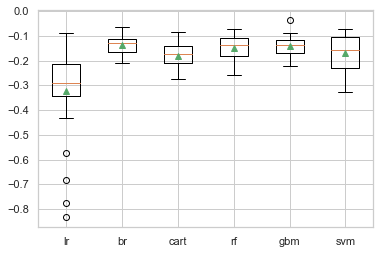

In [378]:
# plot model performance for comparison
#orange line is median, green triangle is mean, box shows variation of scores
plt.boxplot(results, labels=names, showmeans=True)
plt.show()
#we want the model with the highest MAE which is br (bayesian ridge regression)

Multiple Linear Regression:


In [379]:
# split our data into training data and testing data for ML 
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

# print the info about the split data
print('x_train shape is',x_train.shape,'\nx_test shape is',x_test.shape)
print('y_train shape is',y_train.shape,'\ny_test shape is',y_test.shape)
print('y_train means are',round(np.mean(y_train), 3),'\ny_test mean is',round(np.mean(y_test), 3))

x_train shape is (44, 40) 
x_test shape is (15, 40)
y_train shape is (44,) 
y_test shape is (15,)
y_train means are 0.75 
y_test mean is 1.007


In [380]:
#scaling the data to remove outliers
#without scaling the model will be biased towards features with higher values ranges
scaler_x = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(x_train)
scaler_y = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(np.array(y_train).reshape(-1, 1)) 
x_train_s = scaler_x.transform(x_train)
y_train_s = scaler_y.transform(np.array(y_train).reshape(-1, 1))
x_test_s = scaler_x.transform(x_test)
y_test_s = scaler_y.transform(np.array(y_test).reshape(-1, 1))

#linear regression
#fit_intercept=False is used because of one-hot encoding
LRmodel = linear_model.LinearRegression(fit_intercept=False)
#fit the linear regression to our scaled training data
LRmodel.fit(x_train_s,y_train_s)

#we predict scaled y from our scaled test X
y_pred_scale = LRmodel.predict(x_test_s)
#then reverse the scaling on the prediction
y_pred =scaler_y.inverse_transform(y_pred_scale.reshape(-1,1)).reshape(-1)
#return the models prediction for the y_test data

In [381]:
# conevert to numpy values
y_test_a = y_test.to_numpy().flatten()

In [382]:
#a dataframe of the actual y values vs the predicted values
ap = pd.DataFrame({'Actual': y_test_a, 'Predicted': y_pred})
print(ap)

      Actual  Predicted
0   1.327684   0.920442
1   0.806691   0.724225
2   1.155794   1.495796
3   1.779385   1.674042
4   1.360423   1.175160
5   0.545280  -0.067483
6   1.097100   1.402274
7  -0.028892   0.097704
8   1.023288   0.798412
9   0.546585   0.536304
10  0.363351  -0.124708
11  1.089584   1.075904
12  1.387675   1.546379
13  1.405540   1.277318
14  1.239196   1.456302


In [383]:
#R-squared is a statistical measure of how close the data are to the fitted regression line
#R-squared is between 0-1, and generally, the higher the R-squared, the better the model fits your data 
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_pred), 2))
#this is 0.36 so not the best
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_pred)))

# residuals
#residuals are the difference between the actual value and the predicted
#here we are calculating the residuals so we can plot them
residuals = y_test_a - y_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = np.array(y_test_a)[max_idx], np.array(y_pred)[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.62
Mean Absolute Error (Σ|y-pred|/n): 0
Max Error: 1


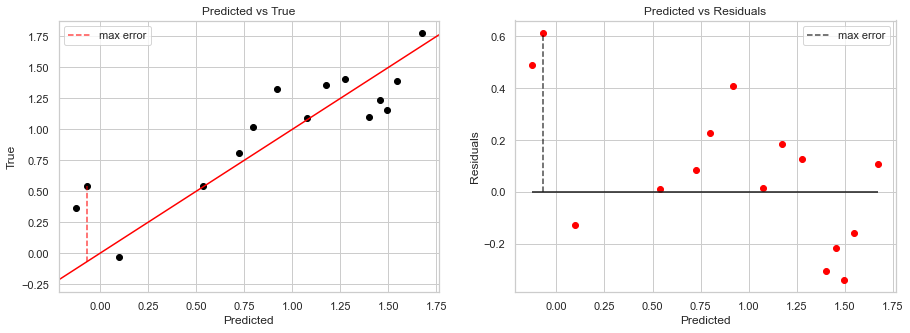

In [384]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax[0].scatter(y_pred, y_test_a, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_pred, ymax=max_pred+max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(y_pred, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_pred), xmax=np.max(y_pred))
ax[1].legend()
plt.savefig('LRmodelPredictions.png',dpi=300)
plt.show()

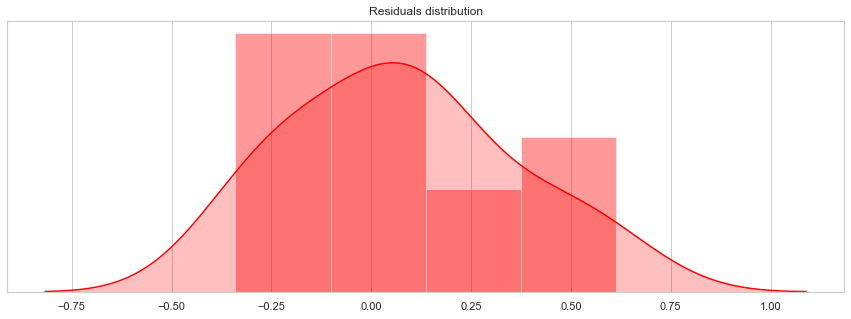

In [385]:
#a residuals distribution plot
fig, ax = plt.subplots(figsize=(15,5))
sn.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.savefig('residuals.png',dpi=300)
plt.show()

Ridge Regression (Using the Model):

In [8]:
# open file 
df = pd.read_excel('IPA.xlsx')
df = df.drop(columns=['Footprint_m2','Modern_Methods_of_Construction_type','Type_of_energy_centre',
                      'Primary_heat_source','Cooling_system','Ventilation','Inpatient_Beds%_Singles',
                      'Organisation/Role_Completing_Template','GIA_Departmental_Gross_(at_ start)_m2',
                     'GIA_(As_Built)_m2', 'Inpatient_Beds_number','Absolute_Duration_day',
                     'Percentage_of_Missing_Data%'])
df = df.dropna(subset=['Outturn_Cost_GBP_UK'])
df.shape

(59, 10)

In [9]:
# change unit of outturn_cost_gbp_uk 
df['Outturn_Cost_GBP_UK'] = df['Outturn_Cost_GBP_UK'] / (10**7)

In [10]:
# one-hot encoding to make categorical data numerical
# drop_first=true is used to break colliarity, as otherwise the linear model will be off
dfn = pd.get_dummies(df,drop_first=True)
dfn.shape

(59, 41)

In [11]:
# as taking log to each data gives better multicollinearity
# use log data for comparing models
for x in dfn.iloc[:, : 4].columns:
    dfn[x] = np.log10(dfn[x])
# Replacing infinite with nan
dfn.replace([np.inf, -np.inf], np.nan, inplace=True)

In [12]:
# imputate by using median method
dfn['Storeys_nr'] = dfn['Storeys_nr'].fillna(dfn['Storeys_nr'].median())
dfn['GIA_Building_Total_(at_start)_m2'] = dfn['GIA_Building_Total_(at_start)_m2'].fillna(dfn['GIA_Building_Total_(at_start)_m2'].median())
dfn['Operating_Theatres_numbers'] = dfn['Operating_Theatres_numbers'].fillna(dfn['Operating_Theatres_numbers'].median())

#splitting data into x and y
X = dfn.drop('Outturn_Cost_GBP_UK', axis=1)
y= dfn['Outturn_Cost_GBP_UK']

In [13]:
# split the test and trainning set 
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [15]:
# when alpha is between (0.01, 100), we tend to obtain better result
# then compare in this range again
print('Ridge regression: effect of alpha regularisation parameter\n')

for this_alpha in [0.01,0.05, 0.10, 0.5,1, 10, 50, 100]:
    linridge = Ridge(alpha = this_alpha).fit(x_train, y_train)
    r2_train = linridge.score(x_train, y_train)
    r2_test = linridge.score(x_test, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:2f}\n\
num abs(coeff) > 1.0:{}, \
r-squared training:{:.2f}, r-squared test:{:.2f}\n'
          .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularisation parameter

Alpha = 0.010000
num abs(coeff) > 1.0:0, r-squared training:0.97, r-squared test:0.82

Alpha = 0.050000
num abs(coeff) > 1.0:0, r-squared training:0.97, r-squared test:0.83

Alpha = 0.100000
num abs(coeff) > 1.0:0, r-squared training:0.97, r-squared test:0.82

Alpha = 0.500000
num abs(coeff) > 1.0:0, r-squared training:0.95, r-squared test:0.79

Alpha = 1.000000
num abs(coeff) > 1.0:0, r-squared training:0.92, r-squared test:0.77

Alpha = 10.000000
num abs(coeff) > 1.0:0, r-squared training:0.65, r-squared test:0.48

Alpha = 50.000000
num abs(coeff) > 1.0:0, r-squared training:0.31, r-squared test:0.05

Alpha = 100.000000
num abs(coeff) > 1.0:0, r-squared training:0.19, r-squared test:-0.10



In [18]:
ridge2 = Ridge(alpha = 0.05, normalize = False)

# Fit a ridge regression on the training data
ridge2.fit(x_train, y_train) 
# Use this model to predict the test data
pred2 = ridge2.predict(x_test) 

# Print coefficientsx for each features
print(pd.Series(ridge2.coef_, index = X.columns))

# print the mean squared error
print('the mean squared error is,', mean_squared_error(y_test, pred2)) 

# print the interceotion
print('ridge regression linear modle intercept:  {}'.format(linridge.intercept_))

# print the R-squared score for training set and test set
print('R-squared score(training): {:.3f}'.format(linridge.score(x_train, y_train)))
print('R-squared score(test): {:.3f}'.format(linridge.score(x_test, y_test)))

# print the number of non-zero features
print('Number of non-zero features: {}'.format(np.sum(linridge.coef_ != 0)))

GIA_Building_Total_(at_start)_m2                                            0.914290
Storeys_nr                                                                  0.022679
Operating_Theatres_numbers                                                  0.121975
Region_East of England                                                     -0.034594
Region_International                                                       -0.209999
Region_London                                                               0.062280
Region_North East                                                          -0.223348
Region_North West                                                           0.029923
Region_Northern Ireland                                                     0.073773
Region_Scotland                                                             0.060114
Region_South East                                                           0.036094
Region_South West                                                

In [19]:
#a dataframe of the actual y values vs the predicted values
y_pred = ridge2.predict(x_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

      Actual  Predicted
26  1.327684   1.299824
35  0.806691   0.650097
43  1.155794   1.285442
28  1.779385   1.320257
11  1.360423   1.313767
2   0.545280   0.270417
34  1.097100   0.995453
46 -0.028892   0.045068
40  1.023288   0.817180
22  0.546585   0.536853
4   0.363351   0.126762
10  1.089584   0.991949
30  1.387675   1.145568
41  1.405540   1.328532
33  1.239196   1.114453


In [20]:
#R-squared is a statistical measure of how close the data are to the fitted regression line
#R-squared is between 0-1, and generally, the higher the R-squared, the better the model fits your data 
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_pred), 2))
# the value of R-squared is ridiculous!
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_pred)))

# residuals
#residuals are the difference between the actual value and the predicted
#here we are calculating the residuals so we can plot them
residuals = y_test - y_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = np.array(y_test)[max_idx], np.array(y_pred)[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.83
Mean Absolute Error (Σ|y-pred|/n): 0
Max Error: 0


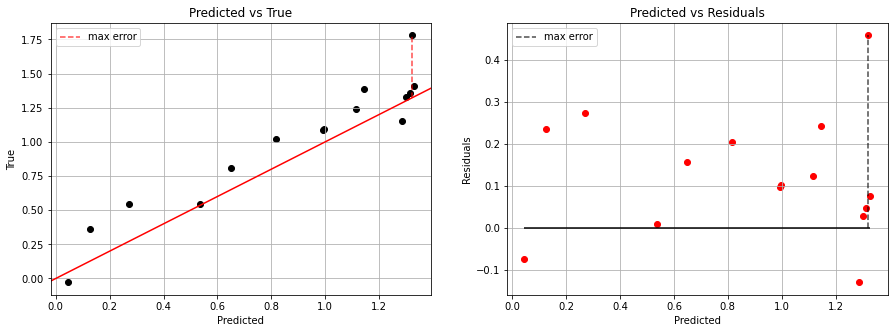

In [21]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax[0].scatter(y_pred, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_pred, ymax=max_pred+max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(y_pred, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_pred), xmax=np.max(y_pred))
ax[1].legend()
plt.savefig('LRmodelPredictions.png',dpi=300)
plt.show()

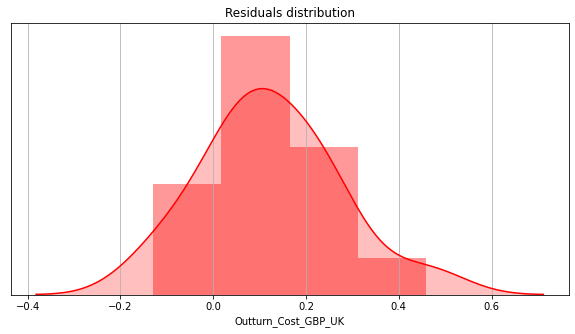

In [22]:
#a residuals distribution plot
fig, ax = plt.subplots(figsize=(10,5))
sn.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.savefig('residuals.png',dpi=300)
plt.show()
#this has a normal distribution which is good

# 4.2 Absolute_Duration_day :

In [68]:
# open file
df = pd.read_excel('IPA.xlsx')
df = df.drop(columns=['Footprint_m2','Modern_Methods_of_Construction_type','Type_of_energy_centre',
                      'Primary_heat_source','Cooling_system','Ventilation','Inpatient_Beds%_Singles',
                      'Organisation/Role_Completing_Template','GIA_Departmental_Gross_(at_ start)_m2',
                     'GIA_(As_Built)_m2', 'Inpatient_Beds_number','Outturn_Cost_GBP_UK',
                     'Percentage_of_Missing_Data%'])
# Drop the Absolute_Duration_day that is smaller than 100 days
df = df[(df['Absolute_Duration_day'] >= 100) | (df['Absolute_Duration_day'].isnull())]
df.shape

(56, 10)

In [69]:
# one-hot encoding to make categorical data numerical
# drop_first=true is used to break colliarity, as otherwise the linear model will be off
dfn = pd.get_dummies(df,drop_first=True)
dfn.shape

(56, 41)

In [70]:
# as taking log to each data gives better multicollinearity
# use log data for comparing models
for x in dfn.iloc[:, : 4].columns:
    dfn[x] = np.log10(dfn[x])

/Users/xiaoyezi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


In [71]:
# Replacing infinite with nan
dfn.replace([np.inf, -np.inf], np.nan, inplace=True)

In [72]:
# imputate by using median method
dfn['Absolute_Duration_day'] = dfn['Absolute_Duration_day'].fillna(dfn['Absolute_Duration_day'].median())
dfn['Storeys_nr'] = dfn['Storeys_nr'].fillna(dfn['Storeys_nr'].median())
dfn['GIA_Building_Total_(at_start)_m2'] = dfn['GIA_Building_Total_(at_start)_m2'].fillna(dfn['GIA_Building_Total_(at_start)_m2'].median())
dfn['Operating_Theatres_numbers'] = dfn['Operating_Theatres_numbers'].fillna(dfn['Operating_Theatres_numbers'].median())
#splitting data into x and y
X = dfn.drop('Absolute_Duration_day', axis=1)
y= dfn['Absolute_Duration_day']

# Split data into x_1, y_1 for AIC and x_2, y_2 for BIC
X_1 = dfn.drop('Absolute_Duration_day', axis=1)
y_1= dfn['Absolute_Duration_day']
X_2= dfn.drop('Absolute_Duration_day', axis=1)
y_2= dfn['Absolute_Duration_day']

AIC:

In [9]:
#add constant to predictor variables
X_1 = sm.add_constant(X_1)

#fit regression model
model = sm.OLS(y_1, X_1).fit()

#view AIC of model
print(model.aic)

-63.40094967277341


BIC:

In [10]:
#add constant to predictor variables
X_2 = sm.add_constant(X_2)

#fit regression model
model = sm.OLS(y_2, X_2).fit()

#view BIC of model
print(model.bic)

15.587766265897443


In [11]:
# rfe works by fitting the ml model, ranking features by importance, discarding the least important fetaure, re-fitting the model
# and then recursively doing this until the selected number of features is left

# implementing rfe using a linear model selecting top 10 features

# create pipeline
rfe = RFE(estimator=linear_model.LinearRegression(fit_intercept=False), n_features_to_select=10)
model = linear_model.LinearRegression(fit_intercept=False)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model using cross validation
# cv splits the data into 10 groups, then takes out one group to be the test data and evaluates it 
# this is repeated so each group is evaluated as the test data, and then the results of all are averaged
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.273 (0.387)


In [12]:
# we can now compare different algoritms to find one with the lowest MAE
# they have to be regression algorithms 
# the algorithm in the rfe also has to be 'A supervised learning estimator with a fit method that provides information about 
#                                          feature importance (e.g. coef_, feature_importances_).'
# https://scikit-learn.org/stable/supervised_learning.html this page lists all supervised learning algorithms in sklearn
# There may be more that could be tested

# get a list of models to evaluate
# we don't yet know the optimum number of features, so I have chosen 25 arbitrarily - this is about 15% of the features
# you don't want to include too many features as some can negatively affect the model's accuracy
def get_models():
	models = dict()
	# linear regresssion
	rfe = RFE(estimator=linear_model.LinearRegression(fit_intercept=False), n_features_to_select=25)
	model = linear_model.LinearRegression(fit_intercept=False)
	models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
	 #bayesian ridge regression
	rfe = RFE(estimator=linear_model.BayesianRidge(), n_features_to_select=25)
	model = linear_model.BayesianRidge()
	models['br'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=25)
	model = DecisionTreeRegressor()
	models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
	# random forest
	rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=25)
	model = RandomForestRegressor()
	models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gradient boosting machine
	rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=25)
	model = GradientBoostingRegressor()
	models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
	# support vector machine
	rfe = RFE(estimator=LinearSVR(random_state=0, tol=1e-5), n_features_to_select=25)
	model = LinearSVR(random_state=0, tol=1e-5)
	models['svm'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

 
# evaluate each model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
    
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>lr -0.179 (0.080)
>br -0.120 (0.051)
>cart -0.144 (0.058)
>rf -0.112 (0.036)
>gbm -0.116 (0.041)
>svm -0.136 (0.038)


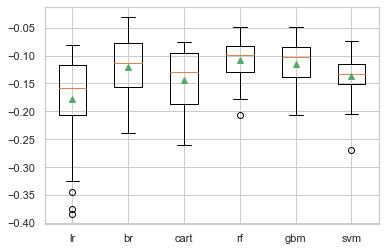

In [406]:
# plot model performance for comparison
#orange line is median, green triangle is mean, box shows variation of scores
#we want the model with the highest MAE which is rf (random forest)
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Ridge Regression:

In [13]:
# split our data into training data and testing data for ML 
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

# print the info about the split data
print('x_train shape is',x_train.shape,'\nx_test shape is',x_test.shape)
print('y_train shape is',y_train.shape,'\ny_test shape is',y_test.shape)
print('y_train means are\n',round(np.mean(y_train), 3),'\ny_test mean is\n',round(np.mean(y_test), 3))

x_train shape is (42, 40) 
x_test shape is (14, 40)
y_train shape is (42,) 
y_test shape is (14,)
y_train means are
 2.984 
y_test mean is
 2.998


In [14]:
# when alpha is between (1, 1000), we tend to obtain better result
# then compare in this range again
print('Ridge regression: effect of alpha regularisation parameter\n')

for this_alpha in [1, 10, 20, 30,50, 70, 100, 500, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(x_train, y_train)
    r2_train = linridge.score(x_train, y_train)
    r2_test = linridge.score(x_test, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:2f}\n\
num abs(coeff) > 1.0:{}, \
r-squared training:{:.2f}, r-squared test:{:.2f}\n'
          .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularisation parameter

Alpha = 1.000000
num abs(coeff) > 1.0:0, r-squared training:0.83, r-squared test:-0.62

Alpha = 10.000000
num abs(coeff) > 1.0:0, r-squared training:0.61, r-squared test:-0.06

Alpha = 20.000000
num abs(coeff) > 1.0:0, r-squared training:0.49, r-squared test:0.03

Alpha = 30.000000
num abs(coeff) > 1.0:0, r-squared training:0.41, r-squared test:0.05

Alpha = 50.000000
num abs(coeff) > 1.0:0, r-squared training:0.32, r-squared test:0.07

Alpha = 70.000000
num abs(coeff) > 1.0:0, r-squared training:0.26, r-squared test:0.06

Alpha = 100.000000
num abs(coeff) > 1.0:0, r-squared training:0.20, r-squared test:0.05

Alpha = 500.000000
num abs(coeff) > 1.0:0, r-squared training:0.05, r-squared test:0.01

Alpha = 1000.000000
num abs(coeff) > 1.0:0, r-squared training:0.03, r-squared test:-0.00



In [20]:
ridge2 = Ridge(alpha = 50, normalize = False)

# Fit a ridge regression on the training data
ridge2.fit(x_train, y_train) 
# Use this model to predict the test data
pred2 = ridge2.predict(x_test) 

# Print coefficients for each features
print('the oefficients are\n,',ridge2.coef_)

# print the mean squared error
print('the mean squared error is,', mean_squared_error(y_test, pred2)) 

# print the interceotion
print('ridge regression linear modle intercept:  {}'.format(linridge.intercept_))

# print the R-squared score for training set and test set
print('R-squared score(training): {:.3f}'.format(linridge.score(x_train, y_train)))
print('R-squared score(test): {:.3f}'.format(linridge.score(x_test, y_test)))

# print the number of non-zero features
print('Number of non-zero features: {}'.format(np.sum(linridge.coef_ != 0)))

the oefficients are
, [ 0.03960698  0.02007156  0.00530305  0.          0.00390429  0.0060656
 -0.00436436 -0.01443445  0.0091254   0.00733112  0.00070015 -0.0005454
  0.00097047 -0.00011537 -0.00391637  0.         -0.02126693 -0.00079594
  0.00733471  0.00390429  0.00509928  0.00813188 -0.0236359  -0.00472109
 -0.0058903  -0.00198736 -0.00671704  0.00314318  0.00448774  0.00391333
 -0.0150828   0.00212283  0.00235684  0.00045479  0.00057523 -0.00238487
 -0.00045862 -0.03475911  0.00434075  0.00197303]
the mean squared error is, 0.015340097768734781
ridge regression linear modle intercept:  2.973865192159188
R-squared score(training): 0.026
R-squared score(test): -0.001
Number of non-zero features: 38


In [21]:
#a dataframe of the actual y values vs the predicted values
y_pred = ridge2.predict(x_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

      Actual  Predicted
48  2.974051   2.997116
35  2.897627   3.025994
42  3.106531   3.001955
26  3.106531   3.055460
11  3.309630   3.002840
2   2.838849   2.923189
34  3.051538   2.996979
46  2.974512   2.986398
49  2.783904   3.029554
32  2.974512   2.996956
4   2.901458   2.931351
10  3.039811   3.000003
30  2.929930   3.026053
22  3.084934   2.999552


In [22]:
#R-squared is a statistical measure of how close the data are to the fitted regression line
#R-squared is between 0-1, and generally, the higher the R-squared, the better the model fits your data 
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_pred), 2))
# the value of R-squared is ridiculous!
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_pred)))

# residuals
#residuals are the difference between the actual value and the predicted
#here we are calculating the residuals so we can plot them
residuals = y_test - y_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = np.array(y_test)[max_idx], np.array(y_pred)[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.07
Mean Absolute Error (Σ|y-pred|/n): 0
Max Error: 0


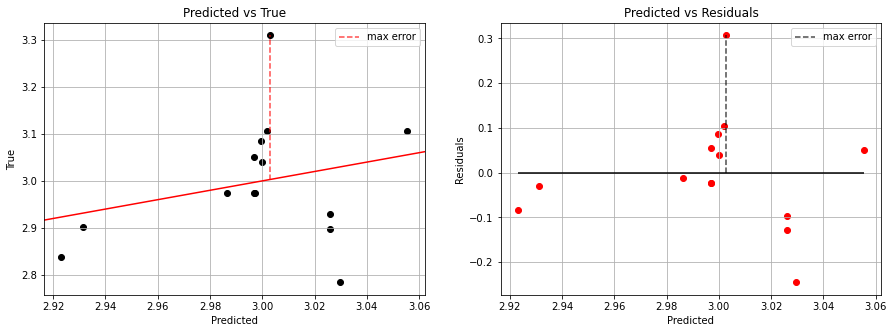

In [23]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax[0].scatter(y_pred, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_pred, ymax=max_pred+max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(y_pred, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_pred), xmax=np.max(y_pred))
ax[1].legend()
plt.savefig('LRmodelPredictions.png',dpi=300)
plt.show()

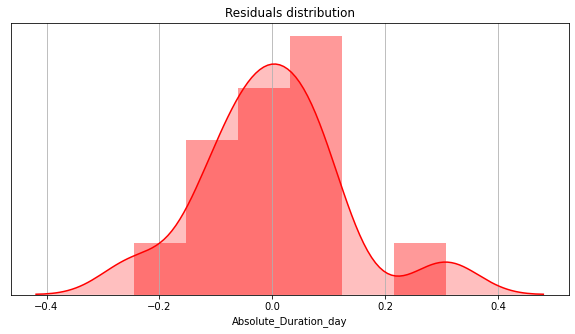

In [24]:
#a residuals distribution plot
fig, ax = plt.subplots(figsize=(10,5))
sn.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.savefig('residuals.png',dpi=300)
plt.show()
#this has a normal distribution which is good

Random Forest (Using the Model):

In [ ]:
# split our data into training data and testing data for ML 
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

# print the info about the split data
print('x_train shape is',x_train.shape,'\nx_test shape is',x_test.shape)
print('y_train shape is',y_train.shape,'\ny_test shape is',y_test.shape)
print('y_train means are\n',round(np.mean(y_train), 3),'\ny_test mean is\n',round(np.mean(y_test), 3))

In [77]:
# Split data into X and y
X= dfn.drop('Absolute_Duration_day', axis=1)
y= dfn['Absolute_Duration_day']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [78]:
# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

In [79]:
print('Training Features Shape:', train_X.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_X.shape)
print('Testing Labels Shape:', test_y.shape)

Training Features Shape: (42, 40)
Training Labels Shape: (42,)
Testing Features Shape: (14, 40)
Testing Labels Shape: (14,)


In [81]:
## Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)
# Train the model on training data
rf.fit(train_X, train_y);

In [82]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)
# Calculate the absolute errors
errors = abs(predictions - test_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.12 degrees.


In [83]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 96.09 %.


In [85]:
# Variable Importances
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:56} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: GIA_Building_Total_(at_start)_m2                         Importance: 0.52
Variable: Storeys_nr                                               Importance: 0.19
Variable: Region_Yorkshire and the Humber                          Importance: 0.07
Variable: Procurement_Path_Trad D&B                                Importance: 0.03
Variable: Region_North East                                        Importance: 0.02
Variable: Building_Category_Specialist hospital                    Importance: 0.02
Variable: Project_Status_Under construction                        Importance: 0.02
Variable: Site_for_development_Greenfield                          Importance: 0.02
Variable: Source_of_costs_Other                                    Importance: 0.02
Variable: Absolute_Duration_day                                    Importance: 0.01
Variable: Region_International                                     Importance: 0.01
Variable: Region_North West                                        Importanc

In [92]:
# Use numpy to convert to arrays
# Labels are the values we want to predict
labels = np.array(dfn['Absolute_Duration_day'])
# Remove the labels from the features
# axis 1 refers to the columns
features= dfn.drop('Absolute_Duration_day', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [94]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=0)
# Extract the two most important features
important_indices = [feature_list.index('GIA_Building_Total_(at_start)_m2'), feature_list.index('Storeys_nr')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.11 degrees.
Accuracy: 96.15 %.


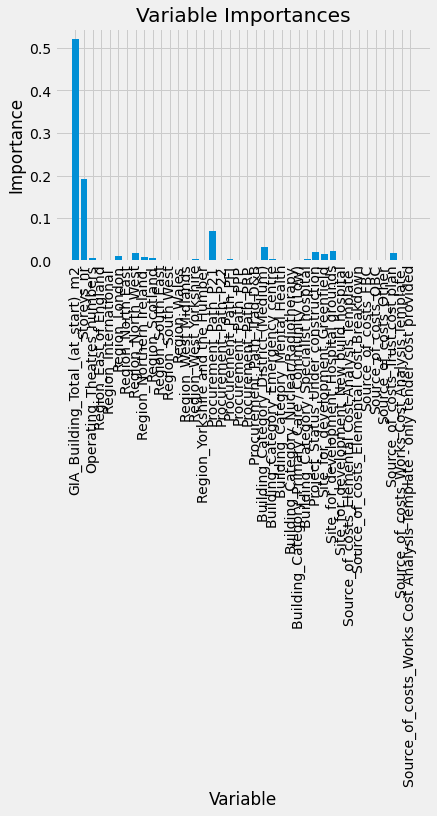

In [121]:
# Visualizations of the variable Importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [151]:
#artifical data to show how to predict
#I have taken 5 rows from the existing data as this is just for demonstrating, not testing
test = dfn  
#selecting 
test = (test[['GIA_Building_Total_(at_start)_m2','Region_Yorkshire and the Humber','Procurement_Path_Trad D&B','Storeys_nr','Building_Category_Specialist hospital',
             'Project_Status_Under construction','Site_for_development_Greenfield','Source_of_costs_Other',
             'Region_North West','Building_Category_District (Medium)',
             'Building_Category_Primary Care / Community (Low)']])

#one hot encoding
Test = pd.get_dummies(test)
#re-index the new data to the columns of the training data, filling the missing values with 0
Test = Test.reindex(columns = dfn.columns, fill_value=0)

#if any imputating is needed, use the median of the TRAINING data not new data

#splitting data
#would only be needed if wanting to compare actaul duration difference with prediction
X_new = Test.drop('Absolute_Duration_day', axis=1)
y_new= dfn['Absolute_Duration_day']


#now we can predict
#model selects only important features
prediction = rf.predict(X_new)

In [150]:
#compared to the actual - but can't be used to evaluate as new data has come from the training data
df = pd.DataFrame({'Actual': y_new, 'Predicted': prediction})
print(df)

      Actual  Predicted
0   2.974512   2.920736
1   3.064458   3.030883
2   2.838849   2.917336
3   2.918030   2.910656
4   2.901458   2.893185
5   2.805501   2.901096
6   2.953760   2.936096
7   2.916980   2.913523
8   2.863917   2.909256
9   2.762679   2.917663
10  3.039811   3.164230
11  3.309630   3.248713
12  3.002598   3.023860
13  2.929419   3.013393
14  2.929930   2.926836
15  2.974512   2.945662
16  3.287578   3.213728
17  3.156549   3.168901
18  2.986772   2.920569
19  3.039811   2.952130
20  2.974512   2.976504
21  2.900913   2.928128
22  3.084934   2.927495
23  3.006466   2.918360
24  3.207904   3.195073
25  3.085647   3.115377
26  3.106531   3.301440
28  3.261739   3.302240
30  2.929930   3.092535
31  2.974512   3.102243
32  2.974512   2.912943
33  3.095866   3.052617
34  3.051538   3.062294
35  2.897627   2.934904
36  3.107210   3.179079
37  3.340841   3.305636
38  3.559068   3.388952
39  2.863323   2.914333
40  3.116608   3.126597
41  3.096562   3.172250
42  3.106531   2